In [ ]:
# from google.colab import drive
# drive.mount("/content/drive")

In [ ]:
# !pip install --quiet missingno
# !pip install --quiet lightgbm
# !pip install bayesian-optimization
# !pip install scikit-optimize

In [30]:
import os
# os.chdir(r"/content/drive/MyDrive/billing_features/raw/")
import math
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import missingno as msno
import pickle
import lightgbm
import xgboost as xgb
#tuning hyperparameters
from bayes_opt import BayesianOptimization
from skopt  import BayesSearchCV 

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score,average_precision_score
from sklearn.metrics import precision_recall_fscore_support 
from sklearn.metrics import roc_curve,precision_recall_curve
from sklearn.metrics import auc as auc_score
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_dir=os.getcwd()
os.listdir()

['PolicyPremium_Combined.csv',
 'Data Dictionary v4.xlsx',
 'Anniv_RG_Data_POLICY_2017_2022YTD.txt',
 'buffer_0.ipynb',
 'Trident_Data_Explore_0708.ipynb',
 'Trident_Data_Explore_0709.ipynb',
 'churn_labels.csv',
 'Trident_Data_Explore_v3.ipynb',
 'Trident_Data_Explore_0715.ipynb',
 'Trident_Data_Explore_0714.ipynb']

In [3]:
start=time.time()
policy_premium_df = pd.read_csv(os.path.join(data_dir,'PolicyPremium_Combined.csv'))
end=time.time()
print("running time {:.4f}".format(end-start))
policy_premium_df.shape

running time 11.7165


(3626285, 25)

In [4]:
churn_labels = pd.read_csv('churn_labels.csv')
churn_labels.dropna(subset=['churn'],inplace=True)
churn_labels.shape

(456829, 9)

In [5]:
policy_id=np.unique(churn_labels['policy_id'].values)
policy_id.shape

(115418,)

In [6]:
policy_premium_df=policy_premium_df[policy_premium_df["policy_id"].isin(policy_id)]
policy_premium_df.shape

(3620385, 25)

In [7]:
policy_premium_df['year']  = policy_premium_df.bill_due_dt.apply(lambda x: x[:4])
policy_premium_df['month'] = policy_premium_df.bill_due_dt.apply(lambda x: x[5:7])
policy_premium_df['policy_id']=policy_premium_df['policy_id'].astype(int)
policy_premium_df['year']=policy_premium_df['year'].apply(str)
policy_premium_df['month']=policy_premium_df['month'].apply(str)
policy_premium_df.drop(['Unnamed: 0','report_start_dt','report_end_dt','bill_due_dt','bill_gen_dt'], axis=1, inplace=True)
policy_premium_df=policy_premium_df.reset_index(drop=True)

In [8]:
pd.set_option('display.max_columns', None)
policy_premium_df.loc[policy_premium_df.policy_id==607176].head()

,policy_id,CountBills,CountBillGens,CountFirstGenBillsPaidFull,CountBillsPaidFull,CountBillsPaid,OrigBillAmt,CurrBillAmt,CurrPaidAmt,PaidBillDueDays,AvgPdBilldueDays,PaidBillLastGenDays,AvgPdBillLstGenDays,AvgBillGenCnt,AvgPaidFullCnt,AvgFirstGenPaidFullCnt,Lag12_cntBillGens,Lag12_cntPaidFull,Lag12_cntFirstGenPaidFull,Lag12_cntBills,year,month
0,607176,1,1,1,1,1,211.31,211.31,211.31,-4,-4,14,14,1.0,1.0,1.0,13,12,11,12,2020,11
28969,607176,1,1,1,1,1,190.98,190.98,190.98,-10,-10,8,8,1.0,1.0,1.0,11,11,11,11,2018,12
40576,607176,1,1,1,1,1,190.98,190.98,190.98,-10,-10,8,8,1.0,1.0,1.0,8,8,8,8,2018,09
168537,607176,1,1,1,1,1,154.70,154.70,154.70,66,66,9,9,1.0,1.0,1.0,13,12,11,12,2020,03
174517,607176,1,1,1,1,1,190.98,190.98,190.98,-5,-5,13,13,1.0,1.0,1.0,NaN,NaN,NaN,NaN,2018,01


In [9]:
policy_premium_df = policy_premium_df.replace('?', np.nan)
policy_premium_df["AvgPdBilldueDays"]=policy_premium_df["AvgPdBilldueDays"].astype(float)
policy_premium_df["AvgPdBillLstGenDays"]=policy_premium_df["AvgPdBillLstGenDays"].astype(float)
policy_premium_df["Lag12_cntBillGens"]=policy_premium_df["Lag12_cntBillGens"].astype(float)
policy_premium_df["Lag12_cntPaidFull"]=policy_premium_df["Lag12_cntPaidFull"].astype(float)
policy_premium_df["Lag12_cntFirstGenPaidFull"]=policy_premium_df["Lag12_cntFirstGenPaidFull"].astype(float)
policy_premium_df["Lag12_cntBills"]=policy_premium_df["Lag12_cntBills"].astype(float)

policy_premium_df['CountBills'] = policy_premium_df['CountBills'].replace(0, np.nan)
policy_premium_df['AvgPdBilldueDays'] = policy_premium_df['AvgPdBilldueDays'].replace(0, np.nan)
policy_premium_df['AvgPdBillLstGenDays'] = policy_premium_df['AvgPdBillLstGenDays'].replace(0, np.nan)
policy_premium_df['AvgBillGenCnt'] = policy_premium_df['AvgBillGenCnt'].replace(0, np.nan)
policy_premium_df['AvgPaidFullCnt'] = policy_premium_df['AvgPaidFullCnt'].replace(0, np.nan)

In [10]:
# policy_premium_df.isnull().sum().sort_values(ascending=False)/len(policy_premium_df)

pd.set_option('display.max_columns', None,'display.max_rows', None)
tempt=pd.DataFrame(policy_premium_df.isnull().sum().sort_values(ascending=False)/len(policy_premium_df)).reset_index()
tempt=tempt[tempt[0]>0]
tempt.rename({"index":"variable",0:"missing %"},axis=1).style.format({"missing %":"{:.2%}"})

,variable,missing %
0,AvgPdBillLstGenDays,8.61%
1,AvgPdBilldueDays,4.98%
2,Lag12_cntBills,3.05%
3,Lag12_cntFirstGenPaidFull,3.05%
4,Lag12_cntPaidFull,3.05%
5,Lag12_cntBillGens,3.05%
6,AvgPaidFullCnt,2.68%


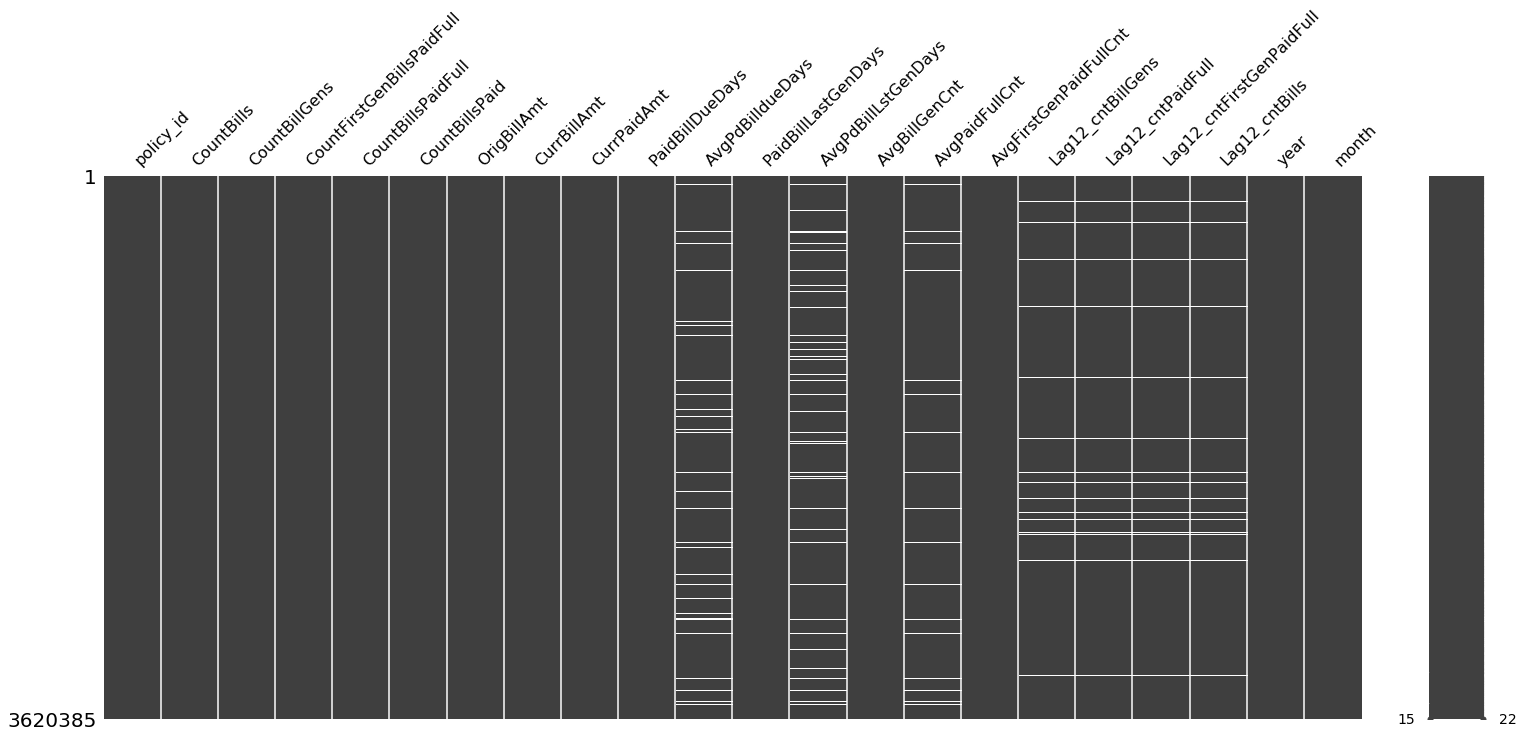

In [11]:
msno.matrix(policy_premium_df)

In [12]:
my_imputer = SimpleImputer()
numeric_columns=[]
categorical_columns=[]
for c in policy_premium_df.columns:
    if policy_premium_df[c].dtypes!="object":
        numeric_columns.append(c)
    else:
        categorical_columns.append(c)

data_numeric=policy_premium_df.loc[:,numeric_columns]
data_numeric=pd.DataFrame(my_imputer.fit_transform(data_numeric),columns=numeric_columns)

data_categorical=policy_premium_df.loc[:,categorical_columns]
policy_premium_df = pd.concat([data_numeric, data_categorical], axis = 1)

In [13]:
policy_premium_df.isnull().sum().sort_values(ascending=False)/len(policy_premium_df)

month                         0.0
year                          0.0
CountBills                    0.0
CountBillGens                 0.0
CountFirstGenBillsPaidFull    0.0
CountBillsPaidFull            0.0
CountBillsPaid                0.0
OrigBillAmt                   0.0
CurrBillAmt                   0.0
CurrPaidAmt                   0.0
PaidBillDueDays               0.0
AvgPdBilldueDays              0.0
PaidBillLastGenDays           0.0
AvgPdBillLstGenDays           0.0
AvgBillGenCnt                 0.0
AvgPaidFullCnt                0.0
AvgFirstGenPaidFullCnt        0.0
Lag12_cntBillGens             0.0
Lag12_cntPaidFull             0.0
Lag12_cntFirstGenPaidFull     0.0
Lag12_cntBills                0.0
policy_id                     0.0
dtype: float64

In [14]:
policy_premium_df['policy_id']=policy_premium_df['policy_id'].astype(int)
policy_premium_df['year']=policy_premium_df['year'].apply(int)
policy_premium_df['month']=policy_premium_df['month'].apply(int)

- $\frac{1}{T}\sum_{i=0}^{T}X_{t-i} \;\;\; T=1,2,3,6,12$
<br/><br/>
- $delta=X_t-X_{t-i} \;\;\; i=1,2,3,6,12$
<br/><br/>
- $ratio=\frac{X_t-X_{t-i}}{X_t} \;\;\; i=1,2,3,6,12$

In [15]:
def policy_df_accumulate(df):
    df.sort_values(['policy_id','year','month'],inplace=True)
    df["paid_bill_prop"]=df['CurrPaidAmt'].astype(float)/df['CurrBillAmt'].astype(float)
    # df["idx"]=df.groupby(['policy_id',"year"]).ngroup()
    exc_col=["policy_id","Lag12_cntBillGens","Lag12_cntPaidFull","Lag12_cntFirstGenPaidFull","Lag12_cntBills","year","month"]
    for col in tqdm(df.columns):
        if col not in exc_col:
            if col not in ["OrigBillAmt","CurrBillAmt","CurrPaidAmt","PaidBillDueDays","AvgPdBilldueDays","PaidBillLastGenDays","AvgPdBillLstGenDays","paid_bill_prop"]:
                df["L12_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(12, min_periods=1).sum()))
                df["L6_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(6, min_periods=1).sum()))
                df["L1_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(1, min_periods=1).sum()))
                df["L2_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(2, min_periods=1).sum()))
                df["L3_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(3, min_periods=1).sum()))
            else:
                df["L12_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(12, min_periods=1).mean()))
                df["L6_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(6, min_periods=1).mean()))
                df["L1_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(1, min_periods=1).mean()))
                df["L2_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(2, min_periods=1).mean()))
                df["L3_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(3, min_periods=1).mean()))  
                
#                 df["std12_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(12, min_periods=1).std()))
#                 df["std6_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(6, min_periods=1).std()))
#                 df["std1_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(1, min_periods=1).std()))
#                 df["std2_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(2, min_periods=1).std()))
#                 df["std3_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(3, min_periods=1).std()))
                
        if col not in ["policy_id","year","month"]:
            df["lag1_"+col]=df[col].shift(1)
            df["d1_"+col]=df[col]-df["lag1_"+col]
            df["r1_"+col]=(df[col]-df["lag1_"+col])/df["lag1_"+col]
            df.drop(["lag1_"+col],axis=1,inplace=True)
            
            df["lag2_"+col]=df[col].shift(2)
            df["d2_"+col]=df[col]-df["lag2_"+col]
            df["r2_"+col]=(df[col]-df["lag2_"+col])/df["lag2_"+col]
            df.drop(["lag2_"+col],axis=1,inplace=True)

            df["lag3_"+col]=df[col].shift(3)
            df["d3_"+col]=df[col]-df["lag3_"+col]
            df["r3_"+col]=(df[col]-df["lag3_"+col])/df["lag3_"+col]
            df.drop(["lag3_"+col],axis=1,inplace=True)
            
            df["lag6_"+col]=df[col].shift(6)
            df["d6_"+col]=df[col]-df["lag6_"+col]
            df["r6_"+col]=(df[col]-df["lag6_"+col])/df["lag6_"+col]
            df.drop(["lag6_"+col],axis=1,inplace=True)
            
            df["lag12_"+col]=df[col].shift(12)
            df["d12_"+col]=df[col]-df["lag12_"+col]
            df["r12_"+col]=(df[col]-df["lag12_"+col])/df["lag12_"+col]
            df.drop(["lag12_"+col],axis=1,inplace=True)
            
    # df.drop(['idx'],axis=1,inplace=True) 
               
    return df

In [16]:
df=policy_df_accumulate(policy_premium_df)

100%|██████████| 23/23 [1:40:17<00:00, 261.61s/it]  


In [17]:
file_output="policy_premium_pickle"
data_dir="/app/models/dij22"
df.to_pickle(os.path.join(data_dir,file_output))

# file_output="policy_premium.csv"
# data_dir="/home/dij22/Trident"
# df.to_csv(os.path.join(data_dir,file_output))

In [3]:
file="policy_premium_pickle"
data_dir="/app/models/dij22"
policy_premium_df=pd.read_pickle(os.path.join(data_dir,file))

# start=time.time()
# file_output="policy_premium.csv"
# policy_premium_df=pd.read_csv(os.path.join(data_dir,file))
# end=time.time()
# print("running time {:.4f}".format(end-start))

In [4]:
pd.set_option('display.max_columns', None)
policy_premium_df.head()

,policy_id,CountBills,CountBillGens,CountFirstGenBillsPaidFull,CountBillsPaidFull,CountBillsPaid,OrigBillAmt,CurrBillAmt,CurrPaidAmt,PaidBillDueDays,AvgPdBilldueDays,PaidBillLastGenDays,AvgPdBillLstGenDays,AvgBillGenCnt,AvgPaidFullCnt,AvgFirstGenPaidFullCnt,Lag12_cntBillGens,Lag12_cntPaidFull,Lag12_cntFirstGenPaidFull,Lag12_cntBills,year,month,paid_bill_prop,L12_CountBills,L6_CountBills,L1_CountBills,L2_CountBills,L3_CountBills,d1_CountBills,r1_CountBills,d2_CountBills,r2_CountBills,d3_CountBills,r3_CountBills,d6_CountBills,r6_CountBills,d12_CountBills,r12_CountBills,L12_CountBillGens,L6_CountBillGens,L1_CountBillGens,L2_CountBillGens,L3_CountBillGens,d1_CountBillGens,r1_CountBillGens,d2_CountBillGens,r2_CountBillGens,d3_CountBillGens,r3_CountBillGens,d6_CountBillGens,r6_CountBillGens,d12_CountBillGens,r12_CountBillGens,L12_CountFirstGenBillsPaidFull,L6_CountFirstGenBillsPaidFull,L1_CountFirstGenBillsPaidFull,L2_CountFirstGenBillsPaidFull,L3_CountFirstGenBillsPaidFull,d1_CountFirstGenBillsPaidFull,r1_CountFirstGenBillsPaidFull,d2_CountFirstGenBillsPaidFull,r2_CountFirstGenBillsPaidFull,d3_CountFirstGenBillsPaidFull,r3_CountFirstGenBillsPaidFull,d6_CountFirstGenBillsPaidFull,r6_CountFirstGenBillsPaidFull,d12_CountFirstGenBillsPaidFull,r12_CountFirstGenBillsPaidFull,L12_CountBillsPaidFull,L6_CountBillsPaidFull,L1_CountBillsPaidFull,L2_CountBillsPaidFull,L3_CountBillsPaidFull,d1_CountBillsPaidFull,r1_CountBillsPaidFull,d2_CountBillsPaidFull,r2_CountBillsPaidFull,d3_CountBillsPaidFull,r3_CountBillsPaidFull,d6_CountBillsPaidFull,r6_CountBillsPaidFull,d12_CountBillsPaidFull,r12_CountBillsPaidFull,L12_CountBillsPaid,L6_CountBillsPaid,L1_CountBillsPaid,L2_CountBillsPaid,L3_CountBillsPaid,d1_CountBillsPaid,r1_CountBillsPaid,d2_CountBillsPaid,r2_CountBillsPaid,d3_CountBillsPaid,r3_CountBillsPaid,d6_CountBillsPaid,r6_CountBillsPaid,d12_CountBillsPaid,r12_CountBillsPaid,L12_OrigBillAmt,L6_OrigBillAmt,L1_OrigBillAmt,L2_OrigBillAmt,L3_OrigBillAmt,d1_OrigBillAmt,r1_OrigBillAmt,d2_OrigBillAmt,r2_OrigBillAmt,d3_OrigBillAmt,r3_OrigBillAmt,d6_OrigBillAmt,r6_OrigBillAmt,d12_OrigBillAmt,r12_OrigBillAmt,L12_CurrBillAmt,L6_CurrBillAmt,L1_CurrBillAmt,L2_CurrBillAmt,L3_CurrBillAmt,d1_CurrBillAmt,r1_CurrBillAmt,d2_CurrBillAmt,r2_CurrBillAmt,d3_CurrBillAmt,r3_CurrBillAmt,d6_CurrBillAmt,r6_CurrBillAmt,d12_CurrBillAmt,r12_CurrBillAmt,L12_CurrPaidAmt,L6_CurrPaidAmt,L1_CurrPaidAmt,L2_CurrPaidAmt,L3_CurrPaidAmt,d1_CurrPaidAmt,r1_CurrPaidAmt,d2_CurrPaidAmt,r2_CurrPaidAmt,d3_CurrPaidAmt,r3_CurrPaidAmt,d6_CurrPaidAmt,r6_CurrPaidAmt,d12_CurrPaidAmt,r12_CurrPaidAmt,L12_PaidBillDueDays,L6_PaidBillDueDays,L1_PaidBillDueDays,L2_PaidBillDueDays,L3_PaidBillDueDays,d1_PaidBillDueDays,r1_PaidBillDueDays,d2_PaidBillDueDays,r2_PaidBillDueDays,d3_PaidBillDueDays,r3_PaidBillDueDays,d6_PaidBillDueDays,r6_PaidBillDueDays,d12_PaidBillDueDays,r12_PaidBillDueDays,L12_AvgPdBilldueDays,L6_AvgPdBilldueDays,L1_AvgPdBilldueDays,L2_AvgPdBilldueDays,L3_AvgPdBilldueDays,d1_AvgPdBilldueDays,r1_AvgPdBilldueDays,d2_AvgPdBilldueDays,r2_AvgPdBilldueDays,d3_AvgPdBilldueDays,r3_AvgPdBilldueDays,d6_AvgPdBilldueDays,r6_AvgPdBilldueDays,d12_AvgPdBilldueDays,r12_AvgPdBilldueDays,L12_PaidBillLastGenDays,L6_PaidBillLastGenDays,L1_PaidBillLastGenDays,L2_PaidBillLastGenDays,L3_PaidBillLastGenDays,d1_PaidBillLastGenDays,r1_PaidBillLastGenDays,d2_PaidBillLastGenDays,r2_PaidBillLastGenDays,d3_PaidBillLastGenDays,r3_PaidBillLastGenDays,d6_PaidBillLastGenDays,r6_PaidBillLastGenDays,d12_PaidBillLastGenDays,r12_PaidBillLastGenDays,L12_AvgPdBillLstGenDays,L6_AvgPdBillLstGenDays,L1_AvgPdBillLstGenDays,L2_AvgPdBillLstGenDays,L3_AvgPdBillLstGenDays,d1_AvgPdBillLstGenDays,r1_AvgPdBillLstGenDays,d2_AvgPdBillLstGenDays,r2_AvgPdBillLstGenDays,d3_AvgPdBillLstGenDays,r3_AvgPdBillLstGenDays,d6_AvgPdBillLstGenDays,r6_AvgPdBillLstGenDays,d12_AvgPdBillLstGenDays,r12_AvgPdBillLstGenDays,L12_AvgBillGenCnt,L6_AvgBillGenCnt,L1_AvgBillGenCnt,L2_AvgBillGenCnt,L3_AvgBillGenCnt,d1_AvgBillGenCnt,r1_AvgBillGenCnt,d2_AvgBillGenCnt,r

In [4]:
policy_premium_df.shape

(3620385, 303)

In [5]:
churn_labels = pd.read_csv('churn_labels.csv')
# churn_labels['policy_id']=churn_labels['policy_id'].astype(int)
# churn_labels['year']=churn_labels['year'].apply(int)
churn_labels.shape

(456829, 9)

In [6]:
def pivot_date(df,buffer):
    policy_id=[]
    year=[]
    month=[]
    pivot_date=[]
    policy_year=[]
    churn=[]
    for index,row in tqdm(df.iterrows(), total=df.shape[0]):
        if np.isnan(row["policy_term_month"]):
            date1=str(row["year"])+str(int(row["policy_eff_month"]))
        else:
            date1=str(row["year"])+str(int(row["policy_term_month"]))
        
        date2=pd.to_datetime(str(date1),format="%Y%m")-pd.offsets.DateOffset(months=buffer)
        policy_id.append(row["policy_id"])
        year.append(date2.year)
        month.append(date2.month)
        
        if int(date1[4:])<10:
            date1=date1[:4]+str(0)+date1[4:]
        pivot_date.append(date1)
        policy_year.append(row["policy_year"])
        churn.append(row["churn"])
    churn_data=pd.DataFrame({"policy_id":policy_id,"pivot_date":pivot_date,"year":year,"month":month,"policy_year":policy_year,"churn":churn})
    # churn_data["month"]=output["month"].apply(lambda x: str(x) if x>=10 else str(0)+str(x))
    churn_data['policy_id']=churn_data['policy_id'].astype(int)
    churn_data['year']=churn_data['year'].apply(int)
    churn_data['month']=churn_data['month'].apply(int)
    return churn_data

In [7]:
churn_data=pivot_date(churn_labels,buffer=3)

100%|██████████| 456829/456829 [03:10<00:00, 2392.27it/s]


In [8]:
# var=policy_premium_df.columns[:50].tolist()
# tempt=policy_premium_df.loc[:,var]
# df=pd.merge(churn_data,tempt,how="inner", on=["policy_id", "year","month"])
start=time.time()
df=pd.merge(churn_data,policy_premium_df,how="inner", on=["policy_id", "year","month"])
end=time.time()
print("running time {:.4f}".format(end-start))

running time 17.5676


In [55]:
# file_output="df_pickle"
# data_dir="/app/models/dij22"
# df.to_pickle(os.path.join(data_dir,file_output))

In [56]:
# file="df_pickle"
# data_dir="/app/models/dij22"
# df=pd.read_pickle(os.path.join(data_dir,file))

In [9]:
df.shape

(283780, 306)

In [11]:
var=["policy_id","pivot_date","year","month","policy_year","churn","CurrPaidAmt","L3_CurrPaidAmt","L6_CurrPaidAmt","L12_CurrPaidAmt"]
df[df.policy_id==151353].loc[:,var]

,policy_id,pivot_date,year,month,policy_year,churn,CurrPaidAmt,L3_CurrPaidAmt,L6_CurrPaidAmt,L12_CurrPaidAmt
652,151353,201804,2018,1,10,0,200.75,200.750000,200.750000,200.750000
653,151353,201904,2019,1,11,0,200.75,200.750000,167.291667,184.020833
654,151353,202004,2020,1,12,0,200.75,200.750000,200.750000,200.750000
655,151353,202104,2021,1,13,1,162.25,149.416667,155.833333,158.583333


In [12]:
var=["policy_id","year","month","CountBillsPaidFull","CountBillsPaid" ,"CurrPaidAmt","L3_CurrPaidAmt","L6_CurrPaidAmt","L12_CurrPaidAmt"]
policy_premium_df[policy_premium_df.policy_id==151353].loc[:,var]

,policy_id,year,month,CountBillsPaidFull,CountBillsPaid,CurrPaidAmt,L3_CurrPaidAmt,L6_CurrPaidAmt,L12_CurrPaidAmt
1542281,151353,2018,1,1.0,1.0,200.75,200.750000,200.750000,200.750000
1247002,151353,2018,2,1.0,1.0,200.75,200.750000,200.750000,200.750000
238759,151353,2018,3,1.0,1.0,200.75,200.750000,200.750000,200.750000
2390473,151353,2018,4,1.0,1.0,200.75,200.750000,200.750000,200.750000
1633907,151353,2018,5,1.0,1.0,200.75,200.750000,200.750000,200.750000
1139574,151353,2018,6,1.0,1.0,200.75,200.750000,200.750000,200.750000
349779,151353,2018,7,1.0,1.0,200.75,200.750000,200.750000,200.750000
2452932,151353,2018,8,1.0,1.0,200.75,200.750000,200.750000,200.750000
1882119,151353,2018,9,1.0,1.0,200.75,200.750000,200.750000,200.750000
1140361,151353,2018,10,0.0,0.0,0.00,133.833333,167.291667,180.675000


In [13]:
var=["policy_id","year","policy_eff_month","policy_term_month","policy_year","churn"]
churn_labels[churn_labels.policy_id==151353].loc[:,var]

,policy_id,year,policy_eff_month,policy_term_month,policy_year,churn
1065,151353.0,2017,4,4.0,9,0
1066,151353.0,2018,4,4.0,10,0
1067,151353.0,2019,4,4.0,11,0
1068,151353.0,2020,4,4.0,12,0
1069,151353.0,2021,4,4.0,13,1


In [14]:
pd.set_option('display.max_columns', None,'display.max_rows', None)
tempt=pd.DataFrame(policy_premium_df.isnull().sum().sort_values(ascending=False)/len(policy_premium_df)).reset_index()
tempt=tempt[tempt[0]>0]
tempt.rename({"index":"variable",0:"missing %"},axis=1).style.format({"missing %":"{:.4%}"})

,variable,missing %
0,r1_CountFirstGenBillsPaidFull,19.7002%
1,r1_AvgFirstGenPaidFullCnt,19.7002%
2,r2_AvgFirstGenPaidFullCnt,18.6482%
3,r2_CountFirstGenBillsPaidFull,18.6482%
4,r3_AvgFirstGenPaidFullCnt,18.0221%
5,r3_CountFirstGenBillsPaidFull,18.0221%
6,r6_AvgFirstGenPaidFullCnt,16.8084%
7,r6_CountFirstGenBillsPaidFull,16.8084%
8,r1_Lag12_cntFirstGenPaidFull,16.6559%
9,r2_Lag12_cntFirstGenPaidFull,16.2465%


In [10]:
df2=df.copy()
df2.dropna(axis = 0, how ='any',inplace=True)
df2.shape

(227406, 306)

In [11]:
print("{:.2%} data was drop".format(1-df2.shape[0]/df.shape[0]))

19.87% data was drop


In [12]:
df2["churn"].value_counts(dropna=False, normalize=True).to_frame().style.format({"churn":"{:.2%}"})

,churn
0,92.63%
1,7.37%


No handles with labels found to put in legend.


<Figure size 720x576 with 0 Axes>

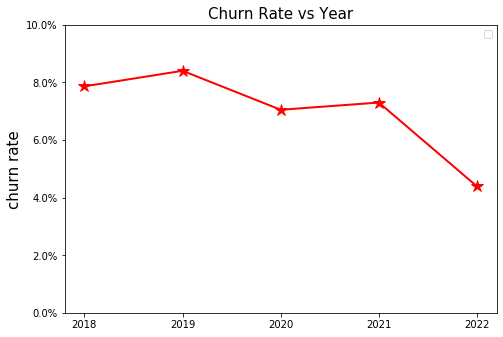

In [13]:
churn_year=df2.groupby(['year']).mean().reset_index().loc[:,["year","churn"]]
churn_year.style.format({"churn":"{.2%}"})

plt.figure(figsize=(10,8))
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1]) # main axes
ax.plot(churn_year["year"],churn_year["churn"],color="r",marker="*",linewidth=2, markersize=12)
ax.set_title("Churn Rate vs Year",fontsize=15)
ax.legend()
ax.set_ylabel("churn rate",fontsize=15)
ax.set_xticks([2018,2019,2020,2021,2022])
ax.set_ylim([0,0.1])
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
plt.show()

Text(0.5, 1.0, 'Distribution of Policy_Year')

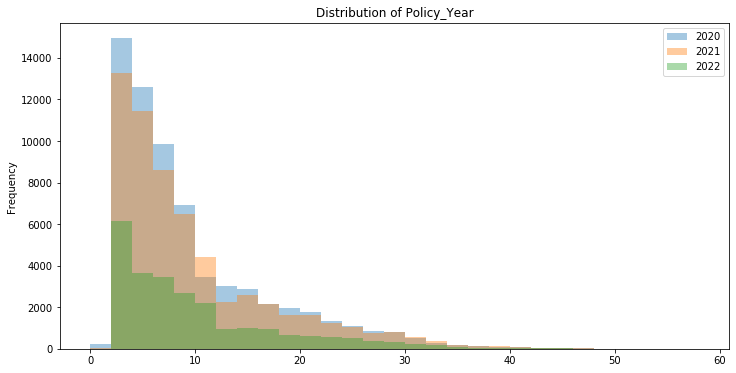

In [100]:
bin_values = np.arange(start=0, stop=60, step=2)
index = df['year'].isin([2020,2021,2022]) 
py = df[index] # select rows
group = py.groupby('year')['policy_year'] 
group.plot(kind='hist', bins=bin_values, figsize=[12,6], alpha=.4, legend=True) # alpha for transparency
plt.title("Distribution of Policy_Year")

Text(0.5, 1.0, 'BoxPlot of Policy_Year')

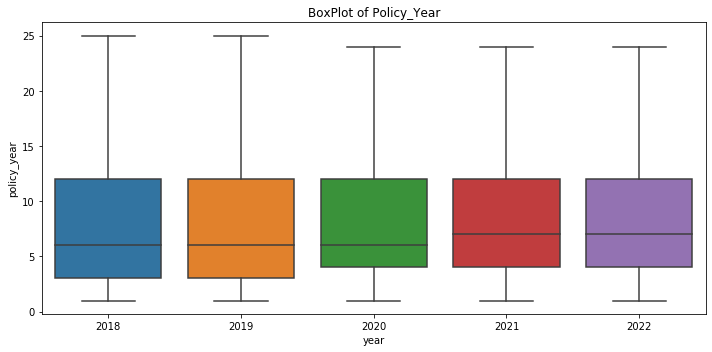

In [113]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True
# ax = sns.boxplot(data = df, x='year',y='policy_year', showfliers = dict(markerfacecolor = '0.50', markersize = 2))
ax = sns.boxplot(data = df, x='year',y='policy_year', showfliers = False)
# for item in ax.get_xticklabels():
#     item.set_rotation(90)
ax.set_title("BoxPlot of Policy_Year")

Text(0.5, 1.0, 'BoxPlot of CurrPaidAmt')

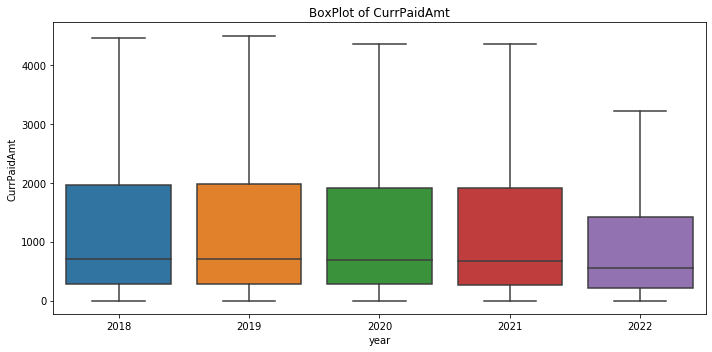

In [131]:
var='CurrPaidAmt'
plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True
# ax = sns.boxplot(data = df, x='year',y=f'{var}', showfliers = dict(markerfacecolor = '0.50', markersize = 2))
ax = sns.boxplot(data = df, x='year',y=f'{var}', showfliers = False)
# for item in ax.get_xticklabels():
#     item.set_rotation(90)
ax.set_title(f"BoxPlot of {var}")

Text(0.5, 1.0, 'BoxPlot of CurrBillAmt')

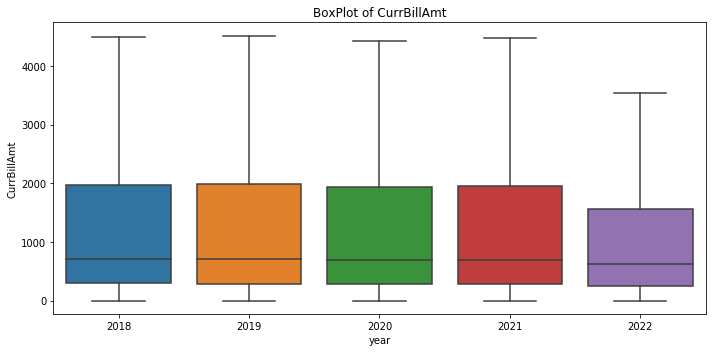

In [132]:
var='CurrBillAmt'
plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True
# ax = sns.boxplot(data = df, x='year',y=f'{var}', showfliers = dict(markerfacecolor = '0.50', markersize = 2))
ax = sns.boxplot(data = df, x='year',y=f'{var}', showfliers = False)
# for item in ax.get_xticklabels():
#     item.set_rotation(90)
ax.set_title(f"BoxPlot of {var}")

In [134]:
# df["paid_bill_prop"]=df['CurrPaidAmt'].astype(float)/df['CurrBillAmt'].astype(float)
var='paid_bill_prop'
df[["year",var]].groupby("year").describe()

paid_bill_prop                                             
              count      mean       std  min  25%  50%  75%  max
year                                                            
2018        67163.0  0.996744  0.052726  0.0  1.0  1.0  1.0  1.0
2019        66556.0  0.997957  0.040581  0.0  1.0  1.0  1.0  1.0
2020        65345.0  0.994230  0.072771  0.0  1.0  1.0  1.0  1.0
2021        59861.0  0.986847  0.111706  0.0  1.0  1.0  1.0  1.0
2022        24855.0  0.947737  0.220082  0.0  1.0  1.0  1.0  1.0

Text(0.5, 1.0, 'BoxPlot of Lag12_cntBills')

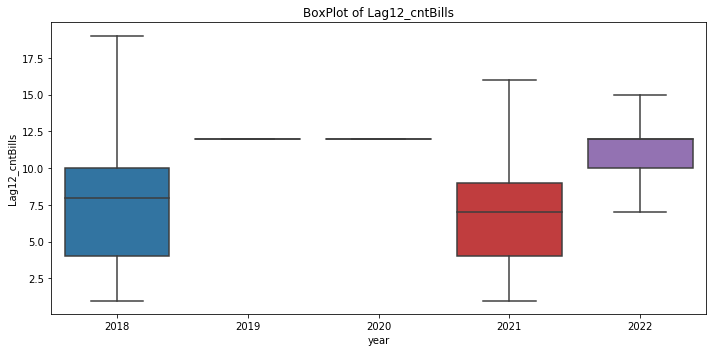

In [125]:
var='Lag12_cntBills'
plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True
# ax = sns.boxplot(data = df, x='year',y=f'{var}', showfliers = dict(markerfacecolor = '0.50', markersize = 2))
ax = sns.boxplot(data = df, x='year',y=f'{var}', showfliers = False)
# for item in ax.get_xticklabels():
#     item.set_rotation(90)
ax.set_title(f"BoxPlot of {var}")
# ax.set_ylim(0,100)

In [120]:
df[["year","Lag12_cntBills"]].groupby("year").describe()

Lag12_cntBills                                                     
              count       mean        std  min   25%   50%   75%     max
year                                                                    
2018        67163.0   9.122933  16.591821  1.0   4.0   8.0  10.0   909.0
2019        66556.0  15.759402  33.579103  1.0  12.0  12.0  12.0  2889.0
2020        65345.0  15.694107  31.760072  1.0  12.0  12.0  12.0  2497.0
2021        59861.0   8.233375  13.527831  1.0   4.0   7.0   9.0   724.0
2022        24855.0  14.076170  33.238524  1.0  10.0  12.0  12.0  2126.0

Text(0.5, 1.0, 'BoxPlot of PaidBillLastGenDays')

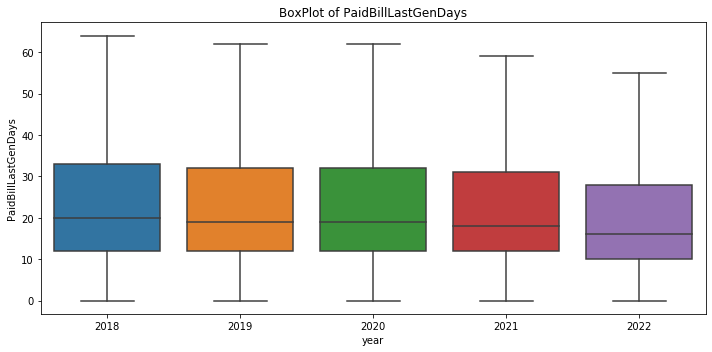

In [118]:
var='PaidBillLastGenDays'
plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True
# ax = sns.boxplot(data = df, x='year',y='policy_year', showfliers = dict(markerfacecolor = '0.50', markersize = 2))
ax = sns.boxplot(data = df, x='year',y=f'{var}', showfliers = False)
# for item in ax.get_xticklabels():
#     item.set_rotation(90)
ax.set_title(f"BoxPlot of {var}")

Text(0.5, 1.0, 'BoxPlot of r12_Lag12_cntBills')

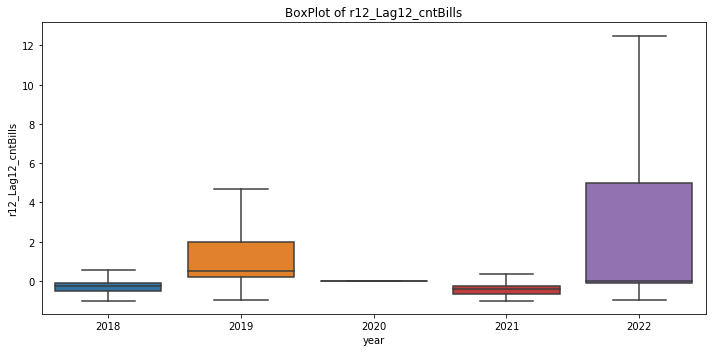

In [116]:
var='r12_Lag12_cntBills'
plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True
# ax = sns.boxplot(data = df, x='year',y='policy_year', showfliers = dict(markerfacecolor = '0.50', markersize = 2))
ax = sns.boxplot(data = df, x='year',y=f'{var}', showfliers = False)
# for item in ax.get_xticklabels():
#     item.set_rotation(90)
ax.set_title(f"BoxPlot of {var}")

In [130]:
var='r12_Lag12_cntBills'
df[["year",var]].groupby("year").describe()

r12_Lag12_cntBills                                                    \
                  count      mean       std       min       25%       50%   
year                                                                        
2018            67162.0  0.167676  2.595730 -0.996528 -0.500000 -0.272727   
2019            66556.0  1.625649  3.209284 -0.989610  0.200000  0.500000   
2020            65345.0  0.120076  1.973704 -0.993873  0.000000  0.000000   
2021            59861.0 -0.374841  0.896394 -0.995902 -0.666667 -0.416667   
2022            24855.0  2.897105  4.627171 -0.964981 -0.100000  0.000000   

                       
           75%    max  
year                   
2018 -0.083333  233.0  
2019  2.000000  283.2  
2020  0.000000  433.0  
2021 -0.250000   66.5  
2022  5.000000  186.0

In [39]:
# # Changing option to use infinite as nan
# pd.set_option('mode.use_inf_as_na', True)
  
# # Dropping all the rows with nan values
# df.dropna(inplace=True)

In [40]:
# my_imputer = SimpleImputer()
# numeric_columns=[]
# categorical_columns=[]
# for c in df.columns:
#     if df[c].dtypes!="object":
#         numeric_columns.append(c)
#     else:
#         categorical_columns.append(c)

# data_numeric=df.loc[:,numeric_columns]
# data_numeric=pd.DataFrame(my_imputer.fit_transform(data_numeric),columns=numeric_columns)

# data_categorical=df.loc[:,categorical_columns]
# df2 = pd.concat([data_numeric, data_categorical], axis = 1)

In [152]:
def model_evaluate(target, predicted):
    
    precision, recall, thresholds = precision_recall_curve(target, predicted)
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    fscore=fscore[~np.isnan(fscore)]
    ix = np.argmax(fscore)
    f1_score=fscore[ix]
    

    auc=roc_auc_score(target, predicted)
    pr_auc=auc_score(recall,precision)

    thrs=thresholds[ix]
    prec=precision[ix]
    reca=recall[ix]

    true_label_mask=[1 if x>=thrs else 0 for i,x in enumerate(predicted)]

    nb_prediction=len(true_label_mask)
    true_prediction=sum(true_label_mask)
    false_prediction=nb_prediction-true_prediction
    accuracy=true_prediction/nb_prediction
    
    return {
        "nb_example":len(target),
        "true_prediction":true_prediction,
        "false_prediction":false_prediction,
        "accuracy":accuracy,
        "precision":prec, 
        "recall":reca, 
        "f1_score":f1_score,
        "AUC":auc,
        "pr_auc":pr_auc
    }
    
### Binary Analysis
        
def pcut_func(df,var,nbin=5):
    df[var]=df[var].astype(float)
    df["cut"]=pd.qcut(df[var],nbin,precision=2,duplicates="drop")
    decile=df.groupby(df["cut"])['churn'].mean().reset_index()
    decile["cut"]=decile["cut"].astype(str)
    return decile

def myplot(df,var,*args):

    fig, a = plt.subplots(len(args)//2,2,figsize=(12,2.5*len(args)))
    a=a.ravel()
    for idx,ax in enumerate(a):
      df=args[idx]
      ax.plot(df["cut"],df["churn"],color="r",marker="*",linewidth=2, markersize=12)
      ax.set_title(var[idx])
      ax.tick_params(labelrotation=45)
    fig.tight_layout()

def hist_plot(df,var,r):

    fig, a = plt.subplots(len(var)//2,2,figsize=(12,2*len(var)))
    a=a.ravel()
    for idx,ax in enumerate(a):
      
      ax.hist(df.loc[:,var[idx]], bins=20,range=r)
      ax.set_title(var[idx])
      ax.set_xlabel(var[idx])
      ax.set_ylabel("Frequency")
    fig.tight_layout()
    
    
# variable_list=df_feature_importance_v3['feature'].values.tolist()[0:30]

# df3=df2.copy()

# nbin=5
# args=[]
# for idx,v in enumerate(variable_list):
#     x=pcut_func(df3,var=variable_list[idx],nbin=nbin)
#     args.append(x)

# myplot(df3,variable_list,*args)

#### ### original feature + rolling window feature + delta feature + ratio feature

In [153]:
df3=df2.copy()
# exclude_cols=['policy_id', 'pivot_date', 'churn']
# df3["year"]=df3["year"].astype('category')
# df3["month"]=df3["month"].astype('category')

exclude_cols=['policy_id', 'pivot_date', 'churn',"year","month"]

# target=df3.loc[:,["year","churn"]]
# feature=df3.drop(exclude_cols, axis=1)
# X_train,X_test,y_train,y_test=train_test_split(feature,target,test_size=0.25,stratify=target,random_state=101)

train_data=df3[df3["year"]!=2022]
test_data=df3[df3["year"]==2022]

y_train=train_data.loc[:,"churn"]
y_test=test_data.loc[:,"churn"]
X_train=train_data.drop(exclude_cols, axis=1)
X_test=test_data.drop(exclude_cols, axis=1)


print("{:<30}{:<20,}".format('training features: ', len(X_train)))
print("{:<30}{:<20,}".format('testing features: ', len(X_test)))
# print("{:<30}{:<20,}".format('training features: ', len(y_train)))
# print("{:<30}{:<20,}".format('testing features: ', len(y_test)))
# print(y_train.value_counts(dropna=False,normalize=True).to_frame())
pd.DataFrame(y_test, columns=["churn"])["churn"].value_counts(dropna=False,normalize=True).to_frame().style.format({"churn":"{:.2%}"})

training features:            206,569             
testing features:             20,837              


,churn
0,95.61%
1,4.39%


#### Tuning Hypterparameters LGBM

In [154]:
%%time

def bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=25, n_folds=3, random_seed=6,n_estimators=10000, output_process=False):
    # prepare data
    train_data = lightgbm.Dataset(data=X, label=y, free_raw_data=False)

    # parameters
    def lgb_eval(learning_rate,num_leaves, feature_fraction, bagging_fraction, max_depth, max_bin, min_data_in_leaf,min_sum_hessian_in_leaf,subsample):
        params = {'application':'binary', 'metric':'auc'}
        params['learning_rate'] = max(min(learning_rate, 1), 0)
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['max_bin'] = int(round(max_depth))
        params['min_data_in_leaf'] = int(round(min_data_in_leaf))
        params['min_sum_hessian_in_leaf'] = min_sum_hessian_in_leaf
        params['subsample'] = max(min(subsample, 1), 0)
        
        cv_result = lightgbm.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['auc'])
        return max(cv_result['auc-mean'])
     
    lgbBO = BayesianOptimization(lgb_eval, {'learning_rate': (0.01, 1.0),
                                            'num_leaves': (24, 80),
                                            'feature_fraction': (0.1, 0.9),
                                            'bagging_fraction': (0.5, 1),
                                            'max_depth': (5, 30),
                                            'max_bin':(20,90),
                                            'min_data_in_leaf': (10, 100),
                                            'min_sum_hessian_in_leaf':(0,100),
                                           'subsample': (0.01, 1.0)}, random_state=200)

    
    #n_iter: How many steps of bayesian optimization you want to perform. The more steps the more likely to find a good maximum you are.
    #init_points: How many steps of random exploration you want to perform. Random exploration can help by diversifying the exploration space.
    
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    model_auc=[]
    for model in range(len( lgbBO.res)):
        model_auc.append(lgbBO.res[model]['target'])
    
    # return best parameters
    return lgbBO.res[pd.Series(model_auc).idxmax()]['target'],lgbBO.res[pd.Series(model_auc).idxmax()]['params']

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 21.7 µs


In [155]:
opt_params = bayes_parameter_opt_lgb(X_train, y_train, init_round=5, opt_round=10, n_folds=3, random_seed=6,n_estimators=10000)
opt_params[1]["num_leaves"] = int(round(opt_params[1]["num_leaves"]))
opt_params[1]['max_depth'] = int(round(opt_params[1]['max_depth']))
opt_params[1]['min_data_in_leaf'] = int(round(opt_params[1]['min_data_in_leaf']))
opt_params[1]['max_bin'] = int(round(opt_params[1]['max_bin']))
opt_params[1]['objective']='binary'
opt_params[1]['metric']='auc'
opt_params[1]['is_unbalance']=True
opt_params[1]['boost_from_average']=False
opt_params=opt_params[1]
opt_params

|   iter    |  target   | baggin... | featur... | learni... |  max_bin  | max_depth | min_da... | min_su... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
[LightGBM] [Warning] bagging_fraction is set=0.9738161284258351, subsample=0.4615201756036703 will be ignored. Current value: bagging_fraction=0.9738161284258351
[LightGBM] [Warning] bagging_fraction is set=0.9738161284258351, subsample=0.4615201756036703 will be ignored. Current value: bagging_fraction=0.9738161284258351
[LightGBM] [Warning] bagging_fraction is set=0.9738161284258351, subsample=0.4615201756036703 will be ignored. Current value: bagging_fraction=0.9738161284258351
[LightGBM] [Info] Number of positive: 10561, number of negative: 127151
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023661 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if me

{'bagging_fraction': 0.8886859957047621,
 'feature_fraction': 0.5756453319856688,
 'learning_rate': 0.14337744252465245,
 'max_bin': 33,
 'max_depth': 30,
 'min_data_in_leaf': 13,
 'min_sum_hessian_in_leaf': 4.347387000081593,
 'num_leaves': 29,
 'subsample': 0.7175376354183607,
 'objective': 'binary',
 'metric': 'auc',
 'is_unbalance': True,
 'boost_from_average': False}

In [156]:
# categorical_features=['year', 'month']
# train_data = lightgbm.Dataset(X_train, label=y_train,categorical_feature=categorical_features)
train_data = lightgbm.Dataset(X_train, label=y_train)
test_data = lightgbm.Dataset(X_test, label=y_test)
#basic parameter:
# parameters = {
#     'application': 'binary',
#     'objective': 'binary',
#     'metric': 'auc',
#     'is_unbalance': 'true',
#     'boosting': 'gbdt',
#     'max_depth':8,
#     'num_leaves':60,
#     'min_data_in_leaf':300,
#     'feature_fraction': 0.5,
#     'bagging_fraction': 0.5,
#     'bagging_freq': 20,
#     'learning_rate': 0.04,
#     'lambda_l1':1.2,
#     'verbose': 0
# }

# opt_params['lambda_l1']=5
model = lightgbm.train(opt_params,
                       train_data,
                       valid_sets=[train_data,test_data],
                       num_boost_round=5000,
                       early_stopping_rounds=100)

# parameters = {
#     'application': 'binary',
#     'objective': 'binary',
#     'is_unbalance': 'true',
#     'boosting': 'gbdt',
#     'num_leaves': 31,
#     'feature_fraction': 0.5,
#     'bagging_fraction': 0.5,
#     'bagging_freq': 20,
#     'learning_rate': 0.05,
#     'verbose': 0
# }

# from sklearn.metrics import f1_score

# def lgb_f1_score(y_hat, data):
#     y_true = data.get_label()
#     y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
#     return 'f1', f1_score(y_true, y_hat), True

# model = lightgbm.train(parameters,
#                        train_data,
#                        valid_sets=test_data,
#                        num_boost_round=5000,
#                        early_stopping_rounds=100, 
#                        feval=lgb_f1_score
#                       )

[LightGBM] [Warning] bagging_fraction is set=0.8886859957047621, subsample=0.7175376354183607 will be ignored. Current value: bagging_fraction=0.8886859957047621
[LightGBM] [Warning] bagging_fraction is set=0.8886859957047621, subsample=0.7175376354183607 will be ignored. Current value: bagging_fraction=0.8886859957047621
[LightGBM] [Info] Number of positive: 15842, number of negative: 190727
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9695
[LightGBM] [Info] Number of data points in the train set: 206569, number of used features: 301
[LightGBM] [Warning] bagging_fraction is set=0.8886859957047621, subsample=0.7175376354183607 will be ignored. Current value: bagging_fraction=0.8886859957047621
[1]	training's auc: 0.728742	valid_1's auc: 0.58484
Training until validation scores

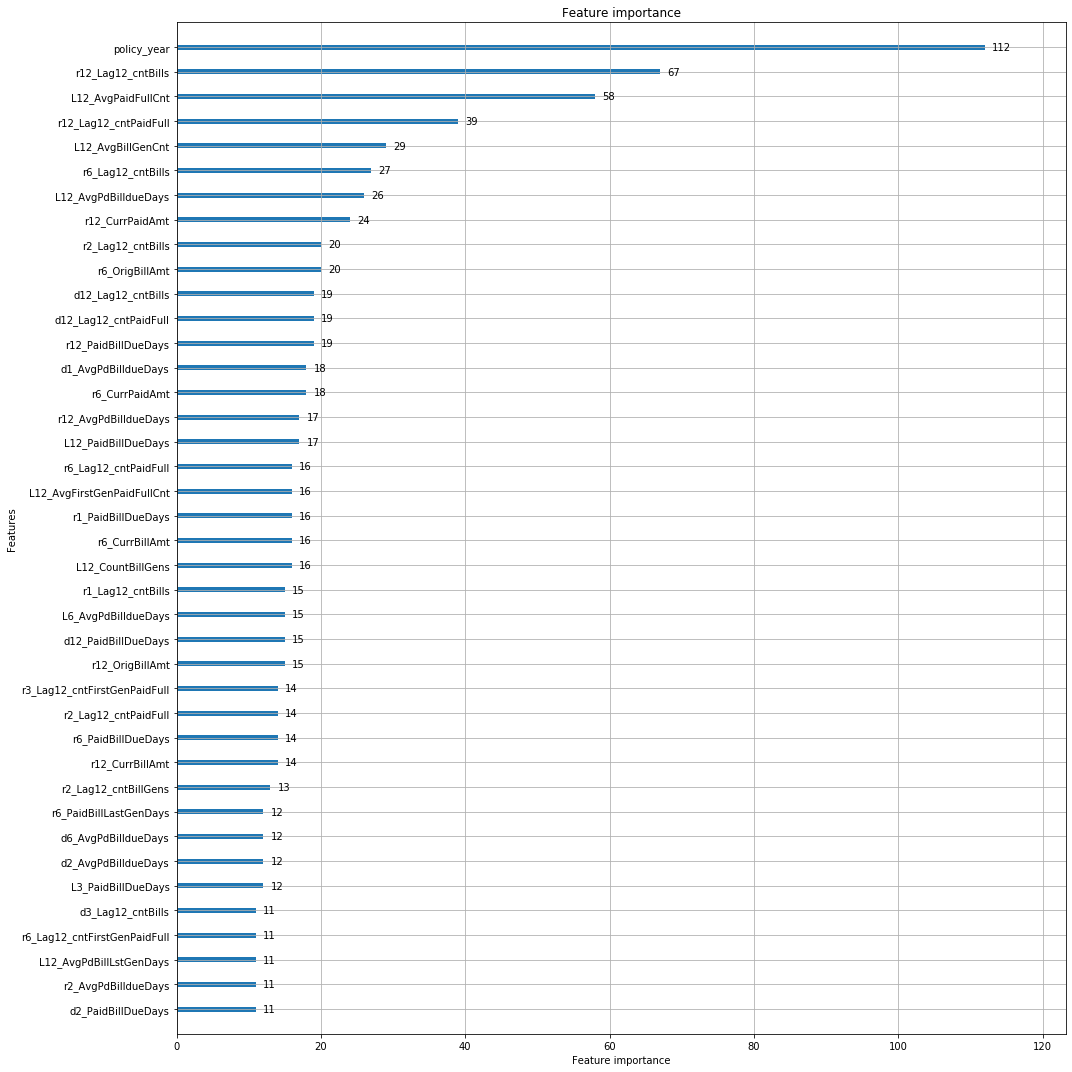

In [157]:
ax = lightgbm.plot_importance(model, max_num_features=40, figsize=(15,15))
plt.show()

In [158]:
df_feature_importance_v4 = (
    pd.DataFrame({
        'feature': model.feature_name(),
        'importance': model.feature_importance(),
    })
    .sort_values('importance', ascending=False)
)
df_feature_importance_v4["rank"]=list(range(len(model.feature_name())))
df_feature_importance_v4=df_feature_importance_v4.loc[:,["rank","feature","importance"]].reset_index(drop=True)
# df_feature_importance_v4.head(20)

In [159]:
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

train_eval_v4=model_evaluate(y_train, train_preds)
test_eval_v4=model_evaluate(y_test, test_preds)

In [160]:
# fpr_train_v3, tpr_train_v3, _ = roc_curve(y_train,  train_preds)
# fpr_test_v3, tpr_test_v3, _ = roc_curve(y_test,  test_preds)

# prec_train_v3, recall_train_v3, _ = precision_recall_curve(y_train,  train_preds)
# prec_test_v3, recall_test_v3, _ = precision_recall_curve(y_test,  test_preds)

In [161]:
# fig = plt.subplots(nrows=1,ncols=2,figsize =(25, 10))
# plt.subplot(1, 2, 1)
# plt.plot(fpr_train_v3, tpr_train_v3, linestyle='solid', label='rolling window features + delta features', color ='purple', linewidth=2)
# plt.plot([0, 1], [0, 1], linestyle='solid', label='random model', color ='darkorange', linewidth=2)
# plt.xlabel('False Positive Rate', fontweight ='bold',fontsize=15)
# plt.ylabel('True Positive Rate', fontweight ='bold',fontsize=15)
# plt.title(f'ROC AUC CURVE \n{"Training"}', fontweight ='bold',fontsize=18)
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# # show the legend
# plt.legend(fontsize="x-large")

# plt.subplot(1, 2, 2)
# plt.plot(fpr_test_v3, tpr_test_v3, linestyle='solid', label='rolling window features + delta features', color ='purple', linewidth=2)
# plt.plot([0, 1], [0, 1], linestyle='solid', label='random model', color ='darkorange', linewidth=2)
# # axis labels
# plt.xlabel('False Positive Rate', fontweight ='bold',fontsize=15)
# plt.ylabel('True Positive Rate', fontweight ='bold',fontsize=15)
# plt.title(f'ROC AUC CURVE \n{"test"}', fontweight ='bold',fontsize=18)

# plt.xlim([0, 1])
# plt.ylim([0, 1])
# # show the legend
# plt.legend(fontsize="x-large")
# # show the plot
# plt.show()

In [162]:
# fig = plt.subplots(nrows=1,ncols=2,figsize =(25, 10))
# plt.subplot(1, 2, 1)
# plt.plot(prec_train_v3, recall_train_v3, linestyle='solid', label='rolling window features + delta features', color ='purple', linewidth=2)

# plt.xlabel('Recall', fontweight ='bold',fontsize=15)
# plt.ylabel('Precision', fontweight ='bold',fontsize=15)
# plt.title(f'Precision Recall CURVE \n{"Training"}', fontweight ='bold',fontsize=18)
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# # show the legend
# plt.legend(fontsize="x-large")

# plt.subplot(1, 2, 2)
# plt.plot(prec_test_v3, recall_test_v3, linestyle='solid', label='rolling window features + delta features', color ='purple', linewidth=2)

# # axis labels
# plt.xlabel('Recall', fontweight ='bold',fontsize=15)
# plt.ylabel('Precision', fontweight ='bold',fontsize=15)
# plt.title(f'Precision Recall CURVE \n{"test"}', fontweight ='bold',fontsize=18)

# plt.xlim([0, 1])
# plt.ylim([0, 1])
# # show the legend
# plt.legend(fontsize="x-large")
# # show the plot
# plt.show()

### ### original feature + rolling window feature

In [163]:
df3=df2.copy()
all_var=df3.columns.tolist()
exclude_var=[]
for col in all_var:
    if col[:2] in ['d1','d2','d3','d6','d12',"r1","r2","r3","r6","r12"]:
        exclude_var.append(col)
        
df3.drop(exclude_var, axis=1,inplace=True)

# exclude_cols=['policy_id', 'pivot_date', 'churn']
# df3["year"]=df3["year"].astype('category')
# df3["month"]=df3["month"].astype('category')

exclude_cols=['policy_id', 'pivot_date', 'churn',"year","month"]

# target=df3.loc[:,["year","churn"]]
# feature=df3.drop(exclude_cols, axis=1)
# X_train,X_test,y_train,y_test=train_test_split(feature,target,test_size=0.25,stratify=target,random_state=101)

train_data=df3[df3["year"]!=2022]
test_data=df3[df3["year"]==2022]

y_train=train_data.loc[:,"churn"]
y_test=test_data.loc[:,"churn"]
X_train=train_data.drop(exclude_cols, axis=1)
X_test=test_data.drop(exclude_cols, axis=1)


print("{:<30}{:<20,}".format('training features: ', len(X_train)))
print("{:<30}{:<20,}".format('testing features: ', len(X_test)))

pd.DataFrame(y_test, columns=["churn"])["churn"].value_counts(dropna=False,normalize=True).to_frame().style.format({"churn":"{:.2%}"})



# df3=df2.copy()
# all_var=df3.columns.tolist()
# exclude_var=[]
# for col in all_var:
#     if col[:2] in ["d1","d2","d3","d6","d12","r1","r2","r3","r6","r12"]:
#         exclude_var.append(col)
# X_train.drop(exclude_var, axis=1,inplace=True)
# X_test.drop(exclude_var, axis=1,inplace=True)

training features:            206,569             
testing features:             20,837              


,churn
0,95.61%
1,4.39%


In [164]:
opt_params = bayes_parameter_opt_lgb(X_train, y_train, init_round=5, opt_round=10, n_folds=3, random_seed=6,n_estimators=10000)
opt_params[1]["num_leaves"] = int(round(opt_params[1]["num_leaves"]))
opt_params[1]['max_depth'] = int(round(opt_params[1]['max_depth']))
opt_params[1]['min_data_in_leaf'] = int(round(opt_params[1]['min_data_in_leaf']))
opt_params[1]['max_bin'] = int(round(opt_params[1]['max_bin']))
opt_params[1]['objective']='binary'
opt_params[1]['metric']='auc'
opt_params[1]['is_unbalance']=True
opt_params[1]['boost_from_average']=False
opt_params=opt_params[1]
opt_params

|   iter    |  target   | baggin... | featur... | learni... |  max_bin  | max_depth | min_da... | min_su... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
[LightGBM] [Warning] bagging_fraction is set=0.9738161284258351, subsample=0.4615201756036703 will be ignored. Current value: bagging_fraction=0.9738161284258351
[LightGBM] [Warning] bagging_fraction is set=0.9738161284258351, subsample=0.4615201756036703 will be ignored. Current value: bagging_fraction=0.9738161284258351
[LightGBM] [Warning] bagging_fraction is set=0.9738161284258351, subsample=0.4615201756036703 will be ignored. Current value: bagging_fraction=0.9738161284258351
[LightGBM] [Info] Number of positive: 10561, number of negative: 127151
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if me

{'bagging_fraction': 0.8201967322055969,
 'feature_fraction': 0.5869250335390612,
 'learning_rate': 0.11437976620936573,
 'max_bin': 88,
 'max_depth': 24,
 'min_data_in_leaf': 71,
 'min_sum_hessian_in_leaf': 32.93481038105413,
 'num_leaves': 25,
 'subsample': 0.805623782185316,
 'objective': 'binary',
 'metric': 'auc',
 'is_unbalance': True,
 'boost_from_average': False}

In [165]:
# categorical_features=['year', 'month']
# train_data = lightgbm.Dataset(X_train, label=y_train,categorical_feature=categorical_features)
train_data = lightgbm.Dataset(X_train, label=y_train)
test_data = lightgbm.Dataset(X_test, label=y_test)
#basic parameter:
# parameters = {
#     'application': 'binary',
#     'objective': 'binary',
#     'metric': 'auc',
#     'is_unbalance': 'true',
#     'boosting': 'gbdt',
#     'num_leaves': 31,
#     'feature_fraction': 0.5,
#     'bagging_fraction': 0.5,
#     'bagging_freq': 20,
#     'learning_rate': 0.05,
#     'verbose': 0
# }

model = lightgbm.train(opt_params,
                       train_data,
                       valid_sets=[train_data,test_data],
                       num_boost_round=5000,
                       early_stopping_rounds=100)

[LightGBM] [Warning] bagging_fraction is set=0.8201967322055969, subsample=0.805623782185316 will be ignored. Current value: bagging_fraction=0.8201967322055969
[LightGBM] [Warning] bagging_fraction is set=0.8201967322055969, subsample=0.805623782185316 will be ignored. Current value: bagging_fraction=0.8201967322055969
[LightGBM] [Info] Number of positive: 15842, number of negative: 190727
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8172
[LightGBM] [Info] Number of data points in the train set: 206569, number of used features: 101
[LightGBM] [Warning] bagging_fraction is set=0.8201967322055969, subsample=0.805623782185316 will be ignored. Current value: bagging_fraction=0.8201967322055969
[1]	training's auc: 0.693691	valid_1's auc: 0.699232
Training until validation scores d

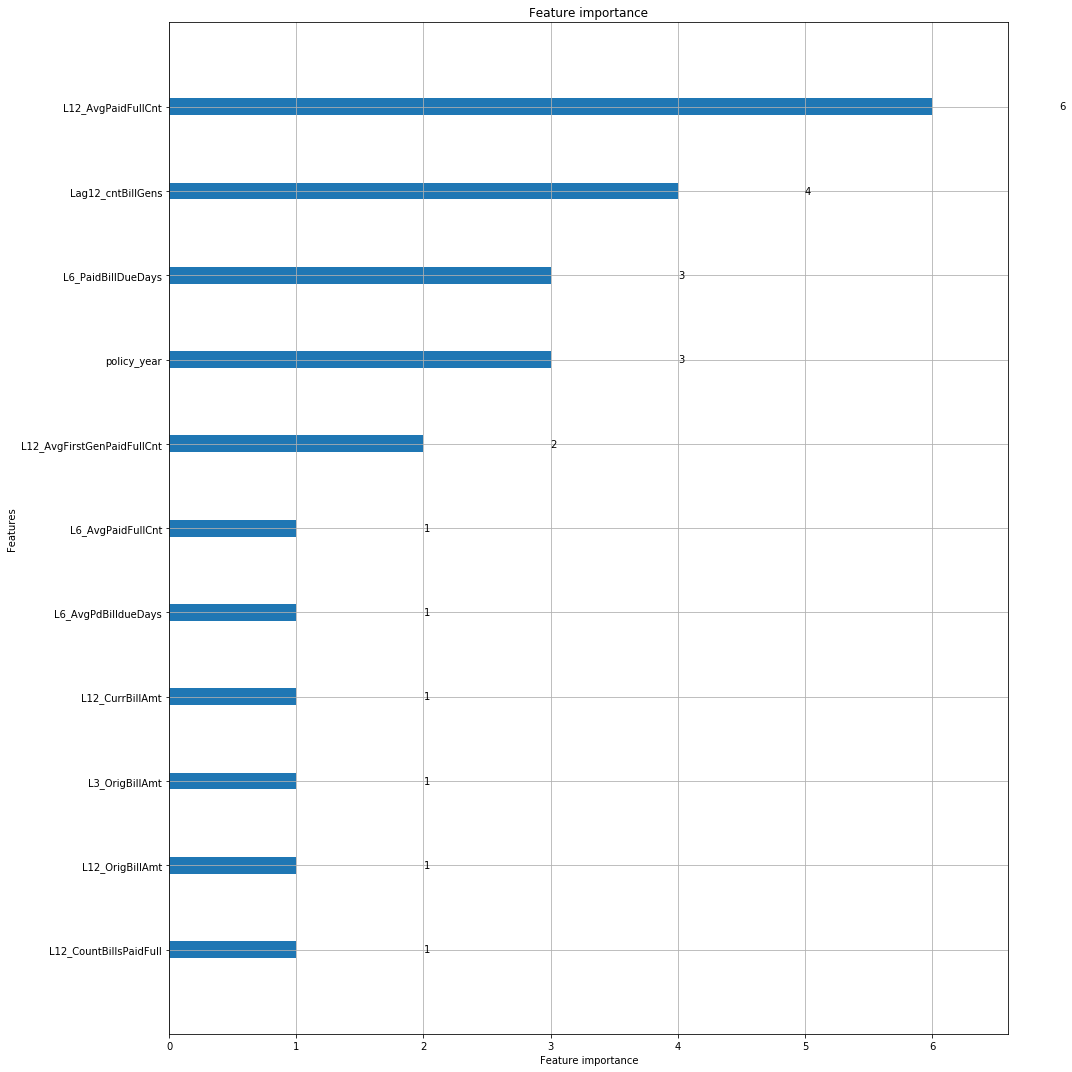

In [166]:
ax = lightgbm.plot_importance(model, max_num_features=40, figsize=(15,15))
plt.show()

In [167]:
df_feature_importance_v2 = (
    pd.DataFrame({
        'feature': model.feature_name(),
        'importance': model.feature_importance(),
    })
    .sort_values('importance', ascending=False)
)
df_feature_importance_v2["rank"]=list(range(len(model.feature_name())))
df_feature_importance_v2=df_feature_importance_v2.loc[:,["rank","feature","importance"]].reset_index(drop=True)
# df_feature_importance_v2.head(20)

In [168]:
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

train_eval_v2=model_evaluate(y_train, train_preds)
test_eval_v2=model_evaluate(y_test, test_preds)

### original feature

In [169]:
df3=df2.copy()
all_var=df3.columns.tolist()
exclude_var=[]
for col in all_var:
    if col[:2] in ["L1","L2","L3","L6","L12",'d1','d2','d3','d6','d12',"r1","r2","r3","r6","r12"]:
        exclude_var.append(col)
        
df3.drop(exclude_var, axis=1,inplace=True)

# exclude_cols=['policy_id', 'pivot_date', 'churn']
# df3["year"]=df3["year"].astype('category')
# df3["month"]=df3["month"].astype('category')

exclude_cols=['policy_id', 'pivot_date', 'churn',"year","month"]

# target=df3.loc[:,["year","churn"]]
# feature=df3.drop(exclude_cols, axis=1)
# X_train,X_test,y_train,y_test=train_test_split(feature,target,test_size=0.25,stratify=target,random_state=101)

train_data=df3[df3["year"]!=2022]
test_data=df3[df3["year"]==2022]

y_train=train_data.loc[:,"churn"]
y_test=test_data.loc[:,"churn"]
X_train=train_data.drop(exclude_cols, axis=1)
X_test=test_data.drop(exclude_cols, axis=1)


print("{:<30}{:<20,}".format('training features: ', len(X_train)))
print("{:<30}{:<20,}".format('testing features: ', len(X_test)))

pd.DataFrame(y_test, columns=["churn"])["churn"].value_counts(dropna=False,normalize=True).to_frame().style.format({"churn":"{:.2%}"})


# df3=df2.copy()
# all_var=df3.columns.tolist()
# exclude_var=[]
# for col in all_var:
#     if col[:2] in ["L1","L2","L3","L6","L12"]:
#         exclude_var.append(col)
# X_train.drop(exclude_var, axis=1,inplace=True)
# X_test.drop(exclude_var, axis=1,inplace=True)
# X_train.columns.tolist()

training features:            206,569             
testing features:             20,837              


,churn
0,95.61%
1,4.39%


In [170]:
opt_params = bayes_parameter_opt_lgb(X_train, y_train, init_round=5, opt_round=10, n_folds=3, random_seed=6,n_estimators=10000)
opt_params[1]["num_leaves"] = int(round(opt_params[1]["num_leaves"]))
opt_params[1]['max_depth'] = int(round(opt_params[1]['max_depth']))
opt_params[1]['min_data_in_leaf'] = int(round(opt_params[1]['min_data_in_leaf']))
opt_params[1]['max_bin'] = int(round(opt_params[1]['max_bin']))
opt_params[1]['objective']='binary'
opt_params[1]['metric']='auc'
opt_params[1]['is_unbalance']=True
opt_params[1]['boost_from_average']=False
opt_params=opt_params[1]
opt_params

|   iter    |  target   | baggin... | featur... | learni... |  max_bin  | max_depth | min_da... | min_su... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
[LightGBM] [Warning] bagging_fraction is set=0.9738161284258351, subsample=0.4615201756036703 will be ignored. Current value: bagging_fraction=0.9738161284258351
[LightGBM] [Warning] bagging_fraction is set=0.9738161284258351, subsample=0.4615201756036703 will be ignored. Current value: bagging_fraction=0.9738161284258351
[LightGBM] [Warning] bagging_fraction is set=0.9738161284258351, subsample=0.4615201756036703 will be ignored. Current value: bagging_fraction=0.9738161284258351
[LightGBM] [Info] Number of positive: 10561, number of negative: 127151
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if me

{'bagging_fraction': 0.8201967322055969,
 'feature_fraction': 0.5869250335390612,
 'learning_rate': 0.11437976620936573,
 'max_bin': 88,
 'max_depth': 24,
 'min_data_in_leaf': 71,
 'min_sum_hessian_in_leaf': 32.93481038105413,
 'num_leaves': 25,
 'subsample': 0.805623782185316,
 'objective': 'binary',
 'metric': 'auc',
 'is_unbalance': True,
 'boost_from_average': False}

In [171]:
# categorical_features=['year', 'month']
# train_data = lightgbm.Dataset(X_train, label=y_train,categorical_feature=categorical_features)
train_data = lightgbm.Dataset(X_train, label=y_train)
test_data = lightgbm.Dataset(X_test, label=y_test)
#basic parameter:
# parameters = {
#     'application': 'binary',
#     'objective': 'binary',
#     'metric': 'auc',
#     'is_unbalance': 'true',
#     'boosting': 'gbdt',
#     'num_leaves': 31,
#     'feature_fraction': 0.5,
#     'bagging_fraction': 0.5,
#     'bagging_freq': 20,
#     'learning_rate': 0.05,
#     'verbose': 0
# }

model = lightgbm.train(opt_params,
                       train_data,
                       valid_sets=[train_data,test_data],
                       num_boost_round=5000,
                       early_stopping_rounds=100)

[LightGBM] [Warning] bagging_fraction is set=0.8201967322055969, subsample=0.805623782185316 will be ignored. Current value: bagging_fraction=0.8201967322055969
[LightGBM] [Warning] bagging_fraction is set=0.8201967322055969, subsample=0.805623782185316 will be ignored. Current value: bagging_fraction=0.8201967322055969
[LightGBM] [Info] Number of positive: 15842, number of negative: 190727
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1669
[LightGBM] [Info] Number of data points in the train set: 206569, number of used features: 21
[LightGBM] [Warning] bagging_fraction is set=0.8201967322055969, subsample=0.805623782185316 will be ignored. Current value: bagging_fraction=0.8201967322055969
[1]	training's auc: 0.635598	valid_1's auc: 0.542607
Training until validation scores do

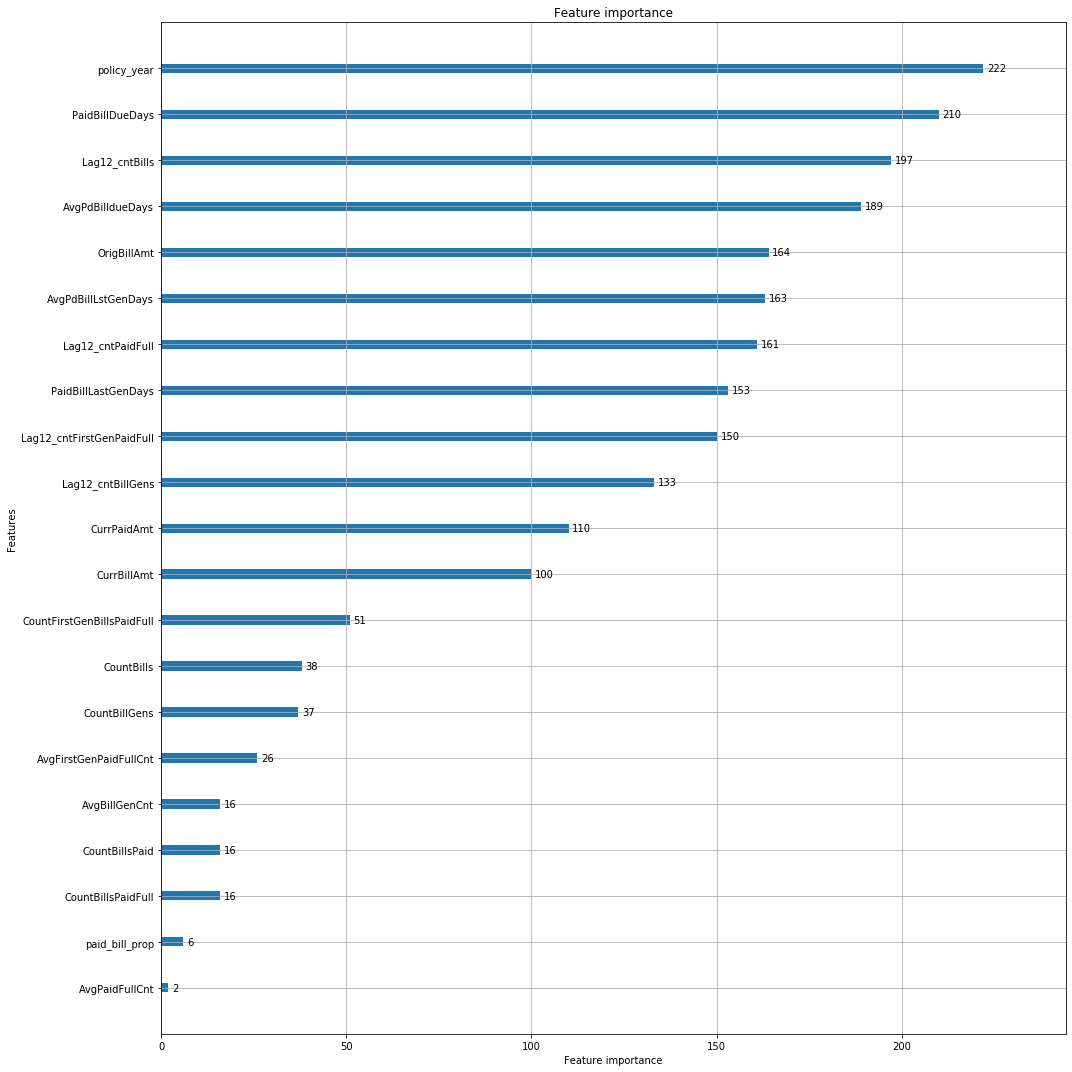

In [172]:
ax = lightgbm.plot_importance(model, max_num_features=40, figsize=(15,15))
plt.show()

In [173]:
df_feature_importance_v1 = (
    pd.DataFrame({
        'feature': model.feature_name(),
        'importance': model.feature_importance(),
    })
    .sort_values('importance', ascending=False)
)
df_feature_importance_v1["rank"]=list(range(len(model.feature_name())))
df_feature_importance_v1=df_feature_importance_v1.loc[:,["rank","feature","importance"]].reset_index(drop=True)
# df_feature_importance_v1.head(20)

In [174]:
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

train_eval_v1=model_evaluate(y_train, train_preds)
test_eval_v1=model_evaluate(y_test, test_preds)

### original feature + rolling window feature + delta feature

In [175]:
df3=df2.copy()
all_var=df3.columns.tolist()
exclude_var=[]
for col in all_var:
    if col[:2] in ["r1","r2","r3","r6","r12"]:
        exclude_var.append(col)
        
df3.drop(exclude_var, axis=1,inplace=True)

# exclude_cols=['policy_id', 'pivot_date', 'churn']
# df3["year"]=df3["year"].astype('category')
# df3["month"]=df3["month"].astype('category')

exclude_cols=['policy_id', 'pivot_date', 'churn',"year","month"]

# target=df3.loc[:,["year","churn"]]
# feature=df3.drop(exclude_cols, axis=1)
# X_train,X_test,y_train,y_test=train_test_split(feature,target,test_size=0.25,stratify=target,random_state=101)

train_data=df3[df3["year"]!=2022]
test_data=df3[df3["year"]==2022]

y_train=train_data.loc[:,"churn"]
y_test=test_data.loc[:,"churn"]
X_train=train_data.drop(exclude_cols, axis=1)
X_test=test_data.drop(exclude_cols, axis=1)


print("{:<30}{:<20,}".format('training features: ', len(X_train)))
print("{:<30}{:<20,}".format('testing features: ', len(X_test)))

pd.DataFrame(y_test, columns=["churn"])["churn"].value_counts(dropna=False,normalize=True).to_frame().style.format({"churn":"{:.2%}"})

training features:            206,569             
testing features:             20,837              


,churn
0,95.61%
1,4.39%


In [176]:
opt_params = bayes_parameter_opt_lgb(X_train, y_train, init_round=5, opt_round=10, n_folds=3, random_seed=6,n_estimators=10000)
opt_params[1]["num_leaves"] = int(round(opt_params[1]["num_leaves"]))
opt_params[1]['max_depth'] = int(round(opt_params[1]['max_depth']))
opt_params[1]['min_data_in_leaf'] = int(round(opt_params[1]['min_data_in_leaf']))
opt_params[1]['max_bin'] = int(round(opt_params[1]['max_bin']))
opt_params[1]['objective']='binary'
opt_params[1]['metric']='auc'
opt_params[1]['is_unbalance']=True
opt_params[1]['boost_from_average']=False
opt_params=opt_params[1]
opt_params

|   iter    |  target   | baggin... | featur... | learni... |  max_bin  | max_depth | min_da... | min_su... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
[LightGBM] [Warning] bagging_fraction is set=0.9738161284258351, subsample=0.4615201756036703 will be ignored. Current value: bagging_fraction=0.9738161284258351
[LightGBM] [Warning] bagging_fraction is set=0.9738161284258351, subsample=0.4615201756036703 will be ignored. Current value: bagging_fraction=0.9738161284258351
[LightGBM] [Warning] bagging_fraction is set=0.9738161284258351, subsample=0.4615201756036703 will be ignored. Current value: bagging_fraction=0.9738161284258351
[LightGBM] [Info] Number of positive: 10561, number of negative: 127151
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if me

{'bagging_fraction': 0.5744938918679026,
 'feature_fraction': 0.7885502969399288,
 'learning_rate': 0.18599404165928793,
 'max_bin': 23,
 'max_depth': 30,
 'min_data_in_leaf': 93,
 'min_sum_hessian_in_leaf': 2.5453525291160073,
 'num_leaves': 75,
 'subsample': 0.129216126293004,
 'objective': 'binary',
 'metric': 'auc',
 'is_unbalance': True,
 'boost_from_average': False}

In [177]:
# categorical_features=['year', 'month']
# train_data = lightgbm.Dataset(X_train, label=y_train,categorical_feature=categorical_features)
train_data = lightgbm.Dataset(X_train, label=y_train)
test_data = lightgbm.Dataset(X_test, label=y_test)
#basic parameter:
# parameters = {
#     'application': 'binary',
#     'objective': 'binary',
#     'metric': 'auc',
#     'is_unbalance': 'true',
#     'boosting': 'gbdt',
#     'num_leaves': 31,
#     'feature_fraction': 0.5,
#     'bagging_fraction': 0.5,
#     'bagging_freq': 20,
#     'learning_rate': 0.05,
#     'verbose': 0
# }

model = lightgbm.train(opt_params,
                       train_data,
                       valid_sets=[train_data,test_data],
                       num_boost_round=5000,
                       early_stopping_rounds=100)

[LightGBM] [Warning] bagging_fraction is set=0.5744938918679026, subsample=0.129216126293004 will be ignored. Current value: bagging_fraction=0.5744938918679026
[LightGBM] [Warning] bagging_fraction is set=0.5744938918679026, subsample=0.129216126293004 will be ignored. Current value: bagging_fraction=0.5744938918679026
[LightGBM] [Info] Number of positive: 15842, number of negative: 190727
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.105359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4540
[LightGBM] [Info] Number of data points in the train set: 206569, number of used features: 201
[LightGBM] [Warning] bagging_fraction is set=0.5744938918679026, subsample=0.129216126293004 will be ignored. Current value: bagging_fraction=0.5744938918679026
[1]	training's auc: 0.746946	valid_1's auc: 0.591086
Training until validation scores don't improve for 100 rounds
[2]	training's auc: 0.753742	valid_1

In [178]:
df_feature_importance_v3 = (
    pd.DataFrame({
        'feature': model.feature_name(),
        'importance': model.feature_importance(),
    })
    .sort_values('importance', ascending=False)
)
df_feature_importance_v3["rank"]=list(range(len(model.feature_name())))
df_feature_importance_v3=df_feature_importance_v3.loc[:,["rank","feature","importance"]].reset_index(drop=True)
# df_feature_importance_v3.head(20)

In [179]:
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

train_eval_v3=model_evaluate(y_train, train_preds)
test_eval_v3=model_evaluate(y_test, test_preds)

In [189]:
def evaluation_table(eval_v1,eval_v2,eval_v3,eval_v4,type):
    dict_data={}
    dict_data["Features"]=["Original feature","rolling window feature","rolling window + delta feature","rolling window + delta feature + ratio feature"]
    # dict_data["# of feature"]=[len(feat_1),len(feat_2),len(feat_3)] 
    dict_data["# of sample"]=[eval_v1['nb_example'],eval_v2['nb_example'],eval_v3['nb_example'],eval_v4['nb_example']]
    # dict_data["true_prediction"]=[eval_v1['true_prediction'],eval_v2['true_prediction'],eval_v3['true_prediction']]
    # dict_data["false_prediction"]=[eval_v1['false_prediction'],eval_v2['false_prediction'],eval_v3['false_prediction']]
    # dict_data["accuracy"]=[eval_v1['accuracy'],eval_v2['accuracy'],eval_v3['accuracy']]
    dict_data["precision"]=[eval_v1['precision'],eval_v2['precision'],eval_v3['precision'],eval_v4['precision']]  
    dict_data["recall"]=[eval_v1['recall'],eval_v2['recall'],eval_v3['recall'],eval_v4['recall']] 
    dict_data["f1_score"]=[eval_v1['f1_score'],eval_v2['f1_score'],eval_v3['f1_score'],eval_v4['f1_score']] 
    dict_data["ROC-AUC"]=[eval_v1['AUC'],eval_v2['AUC'],eval_v3['AUC'],eval_v4['AUC']] 
    dict_data["pr-auc"]=[eval_v1['pr_auc'],eval_v2['pr_auc'],eval_v3['pr_auc'],eval_v4['pr_auc']] 
    data_df=pd.DataFrame(dict_data)
    # data_df=data_df.set_index("Model Type")
    # data_df.style.format({"# of sample":"{:,}","true_prediction":"{:,}","false_prediction":"{:,}","accuracy":"{:.2%}","precision":"{:.2%}","recall":"{:.2%}","f1_score":"{:.2%}","ROC-AUC":"{:.2%}","pr-auc":"{:.2%}"})\
    return data_df.style.format({"# of sample":"{:,}","precision":"{:.2%}","recall":"{:.2%}","f1_score":"{:.2%}","ROC-AUC":"{:.2%}","pr-auc":"{:.2%}"})\
    .set_caption(f"Model Performance Comparison {type}")\
    .set_table_styles([{
        'selector': 'caption',
        'props': [
            ('color', 'red'),
            ('font-size', '20px')
        ]
    }])

In [190]:
evaluation_table(train_eval_v1,train_eval_v2,train_eval_v3,train_eval_v4,"Training Set")

,Features,# of sample,precision,recall,f1_score,ROC-AUC,pr-auc
0,Original feature,"206,569",17.32%,38.81%,23.95%,71.67%,17.49%
1,rolling window feature,"206,569",13.18%,54.69%,21.24%,69.37%,16.12%
2,rolling window + delta feature,"206,569",20.73%,48.01%,28.96%,78.69%,22.18%
3,rolling window + delta feature + ratio feature,"206,569",22.76%,48.88%,31.05%,80.22%,25.32%


In [193]:
evaluation_table(test_eval_v1,test_eval_v2,test_eval_v3,test_eval_v4,"Test Set")

,Features,# of sample,precision,recall,f1_score,ROC-AUC,pr-auc
0,Original feature,"20,837",12.97%,25.16%,17.11%,70.17%,10.59%
1,rolling window feature,"20,837",14.48%,27.13%,18.88%,69.92%,11.61%
2,rolling window + delta feature,"20,837",10.68%,25.93%,15.13%,63.44%,8.59%
3,rolling window + delta feature + ratio feature,"20,837",10.52%,25.71%,14.93%,64.26%,8.45%


In [194]:
f1=df_feature_importance_v1.loc[:30,['rank','feature']].rename(columns={"feature":"original_feature"})
f2=df_feature_importance_v2.loc[:30,['rank','feature']].rename(columns={"feature":"Add rolling window feature"})
f3=df_feature_importance_v3.loc[:30,['rank','feature']].rename(columns={"feature":"Add Delta and Ratio feature"})

feature_importance=pd.merge(f1,f2,how="inner",on="rank")
feature_importance=pd.merge(feature_importance,f3,how="inner",on="rank")
# feature_importance.style.format().set_caption("Top 20 important Features").set_table_styles([{
#     'selector': 'caption',
#     'props': [
#         ('color', 'red'),
#         ('font-size', '20px')
#     ]
# }])
feature_importance

,rank,original_feature,Add rolling window feature,Add Delta and Ratio feature
0,0,policy_year,L12_AvgPaidFullCnt,policy_year
1,1,PaidBillDueDays,Lag12_cntBillGens,d12_Lag12_cntPaidFull
2,2,Lag12_cntBills,policy_year,L12_AvgPaidFullCnt
3,3,AvgPdBilldueDays,L6_PaidBillDueDays,d12_Lag12_cntBills
4,4,OrigBillAmt,L12_AvgFirstGenPaidFullCnt,Lag12_cntBills
5,5,AvgPdBillLstGenDays,L6_AvgPaidFullCnt,d12_Lag12_cntBillGens
6,6,Lag12_cntPaidFull,L6_AvgPdBilldueDays,d6_CurrBillAmt
7,7,PaidBillLastGenDays,L12_CurrBillAmt,L12_AvgPdBilldueDays
8,8,Lag12_cntFirstGenPaidFull,L12_OrigBillAmt,d12_OrigBillAmt
9,9,Lag12_cntBillGens,L12_CountBillsPaidFull,d12_Lag12_cntFirstGenPaidFull


### Only include top 20 most important features

In [79]:
dict_data={}
dict_data["Feature"]=["Original feature","Add rolling window feature","Add Delta and Ratio feature"]
dict_data["ROC_AUC"]=[test_eval_v1['AUC'],test_eval_v2['AUC'],test_eval_v3['AUC']]
dict_data["# of feature"]=[df_feature_importance_v1.shape[0],df_feature_importance_v2.shape[0],df_feature_importance_v3.shape[0]]  

data_df=pd.DataFrame(dict_data)
# data_df=data_df.set_index("Model Type")
data_df.style.format({"ROC_AUC":"{:.2%}"}).set_caption("")\
.set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'red'),
        ('font-size', '20px')
    ]
}])

,Feature,ROC_AUC,# of feature
0,Original feature,69.35%,21
1,Add rolling window feature,69.92%,101
2,Add Delta and Ratio feature,64.26%,301


In [80]:
df3=df2.copy()
# exclude_cols=['policy_id', 'pivot_date', 'churn']
# df3["year"]=df3["year"].astype('category')
# df3["month"]=df3["month"].astype('category')

exclude_cols=['policy_id', 'pivot_date', 'churn',"year","month"]

# target=df3.loc[:,["year","churn"]]
# feature=df3.drop(exclude_cols, axis=1)
# X_train,X_test,y_train,y_test=train_test_split(feature,target,test_size=0.25,stratify=target,random_state=101)

train_data=df3[df3["year"]!=2022]
test_data=df3[df3["year"]==2022]

y_train=train_data.loc[:,"churn"]
y_test=test_data.loc[:,"churn"]
X_train=train_data.drop(exclude_cols, axis=1)
X_test=test_data.drop(exclude_cols, axis=1)

# print("{:<30}{:<20,}".format('training features: ', len(X_train)))
# print("{:<30}{:<20,}".format('testing features: ', len(X_test)))
# # print("{:<30}{:<20,}".format('training features: ', len(y_train)))
# # print("{:<30}{:<20,}".format('testing features: ', len(y_test)))
# # print(y_train.value_counts(dropna=False,normalize=True).to_frame())
# pd.DataFrame(y_test, columns=["churn"])["churn"].value_counts(dropna=False,normalize=True).to_frame().style.format({"churn":"{:.2%}"})

feat_1=feature_importance["original_feature"].values.tolist()
feat_2=feature_importance["Add rolling window feature"].values.tolist()
feat_3=feature_importance["Add Delta and Ratio feature"].values.tolist()
feat_all=feat_1+feat_2+feat_3

In [81]:
opt_params = bayes_parameter_opt_lgb(X_train.loc[:,feat_1], y_train, init_round=5, opt_round=10, n_folds=3, random_seed=6,n_estimators=10000)
opt_params[1]["num_leaves"] = int(round(opt_params[1]["num_leaves"]))
opt_params[1]['max_depth'] = int(round(opt_params[1]['max_depth']))
opt_params[1]['min_data_in_leaf'] = int(round(opt_params[1]['min_data_in_leaf']))
opt_params[1]['max_bin'] = int(round(opt_params[1]['max_bin']))
opt_params[1]['objective']='binary'
opt_params[1]['metric']='auc'
opt_params[1]['is_unbalance']=True
opt_params[1]['boost_from_average']=False
opt_params=opt_params[1]
opt_params

|   iter    |  target   | baggin... | featur... | learni... |  max_bin  | max_depth | min_da... | min_su... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
[LightGBM] [Warning] bagging_fraction is set=0.9738161284258351, subsample=0.4615201756036703 will be ignored. Current value: bagging_fraction=0.9738161284258351
[LightGBM] [Warning] bagging_fraction is set=0.9738161284258351, subsample=0.4615201756036703 will be ignored. Current value: bagging_fraction=0.9738161284258351
[LightGBM] [Warning] bagging_fraction is set=0.9738161284258351, subsample=0.4615201756036703 will be ignored. Current value: bagging_fraction=0.9738161284258351
[LightGBM] [Info] Number of positive: 10561, number of negative: 127151
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if me

{'bagging_fraction': 0.6291201592818791,
 'feature_fraction': 0.6848522025647974,
 'learning_rate': 0.13236430607941427,
 'max_bin': 64,
 'max_depth': 26,
 'min_data_in_leaf': 100,
 'min_sum_hessian_in_leaf': 1.7620163127722188,
 'num_leaves': 25,
 'subsample': 0.31978744423280303,
 'objective': 'binary',
 'metric': 'auc',
 'is_unbalance': True,
 'boost_from_average': False}

In [82]:
train_data_v1 = lightgbm.Dataset(X_train.loc[:,feat_1], label=y_train)
test_data_v1 = lightgbm.Dataset(X_test.loc[:,feat_1], label=y_test)
#basic parameter:
# parameters = {
#     'application': 'binary',
#     'objective': 'binary',
#     'metric': 'auc',
#     'is_unbalance': 'true',
#     'boosting': 'gbdt',
#     'num_leaves': 31,
#     'feature_fraction': 0.5,
#     'bagging_fraction': 0.5,
#     'bagging_freq': 20,
#     'learning_rate': 0.05,
#     'verbose': 0
# }

model = lightgbm.train(opt_params,
                       train_data_v1,
                       valid_sets=test_data_v1,
                       num_boost_round=5000,
                       early_stopping_rounds=100)

[LightGBM] [Warning] bagging_fraction is set=0.6291201592818791, subsample=0.31978744423280303 will be ignored. Current value: bagging_fraction=0.6291201592818791
[LightGBM] [Warning] bagging_fraction is set=0.6291201592818791, subsample=0.31978744423280303 will be ignored. Current value: bagging_fraction=0.6291201592818791
[LightGBM] [Info] Number of positive: 15842, number of negative: 190727
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1245
[LightGBM] [Info] Number of data points in the train set: 206569, number of used features: 21
[LightGBM] [Warning] bagging_fraction is set=0.6291201592818791, subsample=0.31978744423280303 will be ignored. Current value: bagging_fraction=0.6291201592818791
[1]	valid_0's auc: 0.635122
Training until validation scores don't improve for 100

In [83]:
train_preds = model.predict(X_train.loc[:,feat_1])
test_preds = model.predict(X_test.loc[:,feat_1])

train_eval_v1=model_evaluate(y_train, train_preds)
test_eval_v1=model_evaluate(y_test, test_preds)

In [84]:
opt_params = bayes_parameter_opt_lgb(X_train.loc[:,feat_2], y_train, init_round=5, opt_round=10, n_folds=3, random_seed=6,n_estimators=10000)
opt_params[1]["num_leaves"] = int(round(opt_params[1]["num_leaves"]))
opt_params[1]['max_depth'] = int(round(opt_params[1]['max_depth']))
opt_params[1]['min_data_in_leaf'] = int(round(opt_params[1]['min_data_in_leaf']))
opt_params[1]['max_bin'] = int(round(opt_params[1]['max_bin']))
opt_params[1]['objective']='binary'
opt_params[1]['metric']='auc'
opt_params[1]['is_unbalance']=True
opt_params[1]['boost_from_average']=False
opt_params=opt_params[1]
opt_params

|   iter    |  target   | baggin... | featur... | learni... |  max_bin  | max_depth | min_da... | min_su... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
[LightGBM] [Warning] bagging_fraction is set=0.9738161284258351, subsample=0.4615201756036703 will be ignored. Current value: bagging_fraction=0.9738161284258351
[LightGBM] [Warning] bagging_fraction is set=0.9738161284258351, subsample=0.4615201756036703 will be ignored. Current value: bagging_fraction=0.9738161284258351
[LightGBM] [Warning] bagging_fraction is set=0.9738161284258351, subsample=0.4615201756036703 will be ignored. Current value: bagging_fraction=0.9738161284258351
[LightGBM] [Info] Number of positive: 10561, number of negative: 127151
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if me

{'bagging_fraction': 0.8886859957047621,
 'feature_fraction': 0.5756453319856688,
 'learning_rate': 0.14337744252465245,
 'max_bin': 33,
 'max_depth': 30,
 'min_data_in_leaf': 13,
 'min_sum_hessian_in_leaf': 4.347387000081593,
 'num_leaves': 29,
 'subsample': 0.7175376354183607,
 'objective': 'binary',
 'metric': 'auc',
 'is_unbalance': True,
 'boost_from_average': False}

In [85]:
train_data_v2 = lightgbm.Dataset(X_train.loc[:,feat_2], label=y_train)
test_data_v2 = lightgbm.Dataset(X_test.loc[:,feat_2], label=y_test)
#basic parameter:
# parameters = {
#     'application': 'binary',
#     'objective': 'binary',
#     'metric': 'auc',
#     'is_unbalance': 'true',
#     'boosting': 'gbdt',
#     'num_leaves': 31,
#     'feature_fraction': 0.5,
#     'bagging_fraction': 0.5,
#     'bagging_freq': 20,
#     'learning_rate': 0.05,
#     'verbose': 0
# }

model = lightgbm.train(opt_params,
                       train_data_v2,
                       valid_sets=test_data_v2,
                       num_boost_round=5000,
                       early_stopping_rounds=100)

[LightGBM] [Warning] bagging_fraction is set=0.8886859957047621, subsample=0.7175376354183607 will be ignored. Current value: bagging_fraction=0.8886859957047621
[LightGBM] [Warning] bagging_fraction is set=0.8886859957047621, subsample=0.7175376354183607 will be ignored. Current value: bagging_fraction=0.8886859957047621
[LightGBM] [Info] Number of positive: 15842, number of negative: 190727
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002182 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 668
[LightGBM] [Info] Number of data points in the train set: 206569, number of used features: 21
[LightGBM] [Warning] bagging_fraction is set=0.8886859957047621, subsample=0.7175376354183607 will be ignored. Current value: bagging_fraction=0.8886859957047621
[1]	valid_0's auc: 0.662268
Training until validation scores don't improve for 100 rou

In [86]:
train_preds = model.predict(X_train.loc[:,feat_2])
test_preds = model.predict(X_test.loc[:,feat_2])

train_eval_v2=model_evaluate(y_train, train_preds)
test_eval_v2=model_evaluate(y_test, test_preds)

In [87]:
opt_params = bayes_parameter_opt_lgb(X_train.loc[:,feat_3], y_train, init_round=5, opt_round=10, n_folds=3, random_seed=6,n_estimators=10000)
opt_params[1]["num_leaves"] = int(round(opt_params[1]["num_leaves"]))
opt_params[1]['max_depth'] = int(round(opt_params[1]['max_depth']))
opt_params[1]['min_data_in_leaf'] = int(round(opt_params[1]['min_data_in_leaf']))
opt_params[1]['max_bin'] = int(round(opt_params[1]['max_bin']))
opt_params[1]['objective']='binary'
opt_params[1]['metric']='auc'
opt_params[1]['is_unbalance']=True
opt_params[1]['boost_from_average']=False
opt_params=opt_params[1]
opt_params

|   iter    |  target   | baggin... | featur... | learni... |  max_bin  | max_depth | min_da... | min_su... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
[LightGBM] [Warning] bagging_fraction is set=0.9738161284258351, subsample=0.4615201756036703 will be ignored. Current value: bagging_fraction=0.9738161284258351
[LightGBM] [Warning] bagging_fraction is set=0.9738161284258351, subsample=0.4615201756036703 will be ignored. Current value: bagging_fraction=0.9738161284258351
[LightGBM] [Warning] bagging_fraction is set=0.9738161284258351, subsample=0.4615201756036703 will be ignored. Current value: bagging_fraction=0.9738161284258351
[LightGBM] [Info] Number of positive: 10561, number of negative: 127151
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if me

{'bagging_fraction': 0.8886859957047621,
 'feature_fraction': 0.5756453319856688,
 'learning_rate': 0.14337744252465245,
 'max_bin': 33,
 'max_depth': 30,
 'min_data_in_leaf': 13,
 'min_sum_hessian_in_leaf': 4.347387000081593,
 'num_leaves': 29,
 'subsample': 0.7175376354183607,
 'objective': 'binary',
 'metric': 'auc',
 'is_unbalance': True,
 'boost_from_average': False}

In [88]:
train_data_v3 = lightgbm.Dataset(X_train.loc[:,feat_3], label=y_train)
test_data_v3 = lightgbm.Dataset(X_test.loc[:,feat_3], label=y_test)
#basic parameter:
# parameters = {
#     'application': 'binary',
#     'objective': 'binary',
#     'metric': 'auc',
#     'is_unbalance': 'true',
#     'boosting': 'gbdt',
#     'num_leaves': 31,
#     'feature_fraction': 0.5,
#     'bagging_fraction': 0.5,
#     'bagging_freq': 20,
#     'learning_rate': 0.05,
#     'verbose': 0
# }

model = lightgbm.train(opt_params,
                       train_data_v3,
                       valid_sets=test_data_v3,
                       num_boost_round=5000,
                       early_stopping_rounds=100)

[LightGBM] [Warning] bagging_fraction is set=0.8886859957047621, subsample=0.7175376354183607 will be ignored. Current value: bagging_fraction=0.8886859957047621
[LightGBM] [Warning] bagging_fraction is set=0.8886859957047621, subsample=0.7175376354183607 will be ignored. Current value: bagging_fraction=0.8886859957047621
[LightGBM] [Info] Number of positive: 15842, number of negative: 190727
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 683
[LightGBM] [Info] Number of data points in the train set: 206569, number of used features: 21
[LightGBM] [Warning] bagging_fraction is set=0.8886859957047621, subsample=0.7175376354183607 will be ignored. Current value: bagging_fraction=0.8886859957047621
[1]	valid_0's auc: 0.501219
Training until validation scores don't improve for 100 rou

In [89]:
train_preds = model.predict(X_train.loc[:,feat_3])
test_preds = model.predict(X_test.loc[:,feat_3])

train_eval_v3=model_evaluate(y_train, train_preds)
test_eval_v3=model_evaluate(y_test, test_preds)

In [91]:
dict_data={}
dict_data["Feature"]=["Original feature","Add rolling window feature","Add Delta and Ratio feature"]
dict_data["ROC_AUC"]=[test_eval_v1['AUC'],test_eval_v2['AUC'],test_eval_v3['AUC']]
dict_data["# of feature"]=[len(feat_1),len(feat_2),len(feat_3)]  

data_df=pd.DataFrame(dict_data)
# data_df=data_df.set_index("Model Type")
data_df.style.format({"ROC_AUC":"{:.2%}"}).set_caption("")\
.set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'red'),
        ('font-size', '20px')
    ]
}])

,Feature,ROC_AUC,# of feature
0,Original feature,69.97%,21
1,Add rolling window feature,68.86%,21
2,Add Delta and Ratio feature,61.63%,21


In [92]:
evaluation_table(train_eval_v1,train_eval_v2,train_eval_v3,"Training Set")

,Features,# of sample,precision,recall,f1_score,ROC-AUC,pr-auc
0,Original feature,"206,569",18.05%,42.20%,25.29%,73.18%,18.74%
1,rolling window feature,"206,569",13.38%,55.20%,21.54%,69.67%,14.55%
2,rolling window + delta feature,"206,569",19.56%,46.02%,27.45%,77.06%,20.38%


In [93]:
evaluation_table(test_eval_v1,test_eval_v2,test_eval_v3,"Test Set")

,Features,# of sample,precision,recall,f1_score,ROC-AUC,pr-auc
0,Original feature,"20,837",11.98%,27.57%,16.70%,69.97%,10.00%
1,rolling window feature,"20,837",11.10%,30.42%,16.26%,68.86%,14.16%
2,rolling window + delta feature,"20,837",6.76%,45.19%,11.76%,61.63%,6.54%
